In [1]:
from IPython.display import clear_output
!pip install torch==2.2.0
!pip install torch_geometric
!pip install particle
!pip install pennylane
!pip install pennylane-lightning
!pip install pennylane-torch
!pip install torchdata==0.7.1
!pip install torchvision==0.17.0
!pip install qiskit==0.46.0
!pip install torchquantum
!pip install qiskit-ibm-runtime==0.18.0
!pip install qiskit-aer==0.13.2
!pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html
!pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html
!pip install energyflow
clear_output()

In [2]:

!pip list

Package                                  Version            Editable project location
---------------------------------------- ------------------ -------------------------
absl-py                                  1.4.0
accelerate                               0.34.2
aiobotocore                              2.15.1
aiofiles                                 22.1.0
aiohttp                                  3.9.5
aioitertools                             0.12.0
aiosignal                                1.3.1
aiosqlite                                0.20.0
alabaster                                1.0.0
albucore                                 0.0.17
albumentations                           1.4.17
alembic                                  1.13.3
altair                                   5.4.1
annotated-types                          0.7.0
annoy                                    1.17.3
ansicolors                               1.1.8
anyio                                    4.4.0
apache-beam         

In [3]:
nodes_per_graph = nodes_per_graph_original = 7

In [4]:
import torch
import torchdata
import torch.nn as nn
import torch.nn.functional as F
import torchquantum as tq
from torchquantum.layer.entanglement.op2_layer import Op2QAllLayer
from torchquantum.layer.layers.layers import Op1QAllLayer, Op2QAllLayer
from torchquantum.measurement import measure

import numpy as np
import os
from tqdm import tqdm
import scipy
import warnings
import dgl
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn import metrics
from sklearn.preprocessing import normalize

import scipy.sparse as sp
import csv
import time
import pandas as pd
from collections import OrderedDict
from functools import partial
import pickle
import multiprocessing
import joblib

import torch_geometric
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import add_self_loops, degree, softmax
import torch.optim as optim

from copy import deepcopy
import gc

from particle import Particle
import pennylane as qml
import matplotlib.pyplot as plt
%matplotlib inline


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [5]:
## Download the jets along with storing them in a folder for future use, eliminating the need to download them again
main_dir = '/content/'

import energyflow
data = energyflow.qg_jets.load(num_data=20000, pad=True, ncol=4, generator='pythia',
                        with_bc=False, cache_dir=main_dir+'/energyflow')

URL fetch failure on https://www.dropbox.com/s/fclsl7pukcpobsb/QG_jets.npz?dl=1: None -- Bad Request
Failed to download QG_jets.npz from source 'dropbox', trying next source...


In [6]:
jet_file_path = '/content/energyflow/datasets/QG_jets.npz'
data = np.load(jet_file_path)

In [7]:
# @title
### Reference - https://github.com/ML4SCI/QMLHEP/blob/main/Quantum_GNN_for_HEP_Roy_Forestano/utils/preprocess.py

def preprocess_fixed_nodes(x_data,y_data,nodes_per_graph=10): #,masses):
    print('--- Finding All Unique Particles ---')
    unique_particles = np.unique(x_data[:,:,3])
    x_data = torch.tensor(x_data)
    y_data = torch.tensor(y_data)
    print()
    print('--- Inserting Masses ---')
    masses = torch.zeros((x_data.shape[0],x_data.shape[1]))
    for i,particle in tqdm(enumerate(unique_particles)):
        if particle!=0:
            mass = Particle.from_pdgid(particle).mass/1000
            inds = torch.where(particle==x_data[:,:,3])
            masses[inds]=mass # GeV
    print()
    print('--- Calculating Momenta and Energies ---')
    #theta = torch.arctan(torch.exp(-X[:,:,1]))*2 # polar angle
    pt        = x_data[:,:,0]     # transverse momentum
    rapidity  = x_data[:,:,1]     # rapidity
    phi       = x_data[:,:,2]     # azimuthal angle

    mt        = (pt**2+masses**2).sqrt() # Transverse mass
    energy    = mt*torch.cosh(rapidity) # Energy per multiplicity bin
    e_per_jet = energy.sum(axis=1)  # total energy per jet summed across multiplicity bins

    px = pt*torch.cos(phi)  # momentum in x
    py = pt*torch.sin(phi)  # momentum in y
    pz = mt*torch.sinh(rapidity)  # momentum in z

    # three momentum
    p  = torch.cat(( px[:,:,None],
                     py[:,:,None],
                     pz[:,:,None]), dim=2 )

    p_per_jet        = (p).sum(axis=1)  # total componet momentum per jet
    pt_per_Mbin      = (p_per_jet[:,:2]**2).sum(axis=1).sqrt()  # transverse momentum per jet
    mass_per_jet     = (e_per_jet**2-(p_per_jet**2).sum(axis=1)).sqrt() # mass per jet
    rapidity_per_jet = torch.log( (e_per_jet+p_per_jet[:,2])/(e_per_jet-p_per_jet[:,2]) )/2  # rapidity per jet from analytical formula
    end_multiplicity_indx_per_jet = (pt!=0).sum(axis=1).int() # see where the jet (graph) ends

    x_data = torch.cat( ( x_data[:,:,:3],
                          x_data[:,:,4:],
                          masses[:,:,None],
                          energy[:,:,None],
                          p), dim=2)

    x_data_max = (x_data.max(dim=1).values).max(dim=0).values
    x_data = x_data/x_data_max

    print()
    print('--- Calculating Edge Tensors ---')
    N = x_data[:,0,3].shape[0]  # number of jets (graphs)
    M = nodes_per_graph #x_data[0,:,3].shape[0]  # number of max multiplicty
    connections = nodes_per_graph
    edge_tensor = torch.zeros((N,M,M))
    edge_indx_tensor = torch.zeros((N,2,connections*(connections-1) )) # M*(connections-1) is the max number of edges we allow per jet
    edge_attr_matrix = torch.zeros((N,connections*(connections-1),1))
#     fixed_edges_list = torch.tensor([ [i,j] for i in range(connections) for j in range(connections) if i!=j]).reshape(2,90)

    for jet in tqdm(range(N)):
        stop_indx = end_multiplicity_indx_per_jet[jet] #connections # stop finding edges once we hit zeros -> when we hit 10
        if end_multiplicity_indx_per_jet[jet]>=connections:
            for m in range(connections):
#                 inds_edge = np.argsort((energy[jet,m]+energy[jet,:stop_indx])**2-torch.sum((p[jet,m,:stop_indx]+p[jet,:stop_indx,:])**2,axis=1))[:connections]
#                 edge_tensor[jet,m,:] = (energy[jet,m]+energy[jet,:connections])**2-torch.sum((p[jet,m,:]+p[jet,:connections,:])**2,axis=1)
#                 edge_tensor[jet,m,m] = 0.
#                 edge_tensor[jet,m,m]=((energy[jet,m]+energy[jet,m])**2-torch.sum((p[jet,m,:]+p[jet,m,:])**2,axis=0))
                # inds_edge = torch.sqrt( (phi[jet,m]-phi[jet,:])**2 + (rapidity[jet,m]-rapidity[jet,:])**2 ).argsort()[:connections]
                # edge_tensor[jet,m,:] = torch.sqrt( (phi[jet,m]-phi[jet,inds_edge])**2 + (rapidity[jet,m]-rapidity[jet,inds_edge])**2 )
                edge_tensor[jet,m,:] = torch.sqrt( (phi[jet,m]-phi[jet,:connections])**2 + (rapidity[jet,m]-rapidity[jet,:connections])**2 )
#                 inds_edge = np.argsort( (energy[jet,m]+energy[jet,:stop_indx])**2-torch.sum((p[jet,m,:stop_indx]+p[jet,:stop_indx,:])**2,axis=1) )[:connections]
#                 edge_tensor[jet,m,inds_edge] = (energy[jet,m]+energy[jet,inds_edge])**2-torch.sum((p[jet,m,:]+p[jet,inds_edge,:])**2,axis=1)
            edges_exist_at = torch.where(edge_tensor[jet,:,:].abs()>0)

#             edge_indx_tensor[jet,:,:(edge_tensor[jet,:,:].abs()>0).sum()] = fixed_edges_list
            edge_indx_tensor[jet,:,:(edge_tensor[jet,:,:].abs()>0).sum()] = torch.cat((edges_exist_at[0][None,:],edges_exist_at[1][None,:]),dim=0).reshape((2,edges_exist_at[0].shape[0]))
            edge_attr_matrix[jet,:(edge_tensor[jet,:,:].abs()>0).sum(),0]  =  edge_tensor[jet,edges_exist_at[0],edges_exist_at[1]].flatten()

    end_edges_indx_per_jet = (edge_attr_matrix!=0).sum(axis=1).int()
    keep_inds =  torch.where(end_edges_indx_per_jet>=connections)[0]

    edge_tensor = edge_tensor/edge_tensor.max()
    edge_attr_matrix = edge_attr_matrix/edge_attr_matrix.max()

    graph_help = torch.cat( ( (energy.max(axis=1).values/e_per_jet).reshape(x_data[:,0,3].shape[0],1),
                              (mass_per_jet).reshape(x_data[:,0,3].shape[0],1),
                              (end_multiplicity_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int(),
                              (end_edges_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int() ), dim=1)

    return x_data[keep_inds,:nodes_per_graph], y_data[keep_inds].long(), edge_tensor[keep_inds], edge_indx_tensor[keep_inds].long(), edge_attr_matrix[keep_inds], graph_help[keep_inds], masses


In [8]:
# @title
### Reference - https://github.com/bmdillon/JetCLR/blob/main/scripts/modules/jet_augs.py

def distort_jets( batch, strength=0.1, pT_clip_min=0.1 ):
    '''
    Input: batch of jets, shape (batchsize, 3, n_constit)
    dim 1 ordering: (pT, eta, phi)
    Output: batch of jets with each constituents position shifted independently, shifts drawn from normal with mean 0, std strength/pT, same shape as input
    '''
    pT = batch[:,0]   # (batchsize, n_constit)
    shift_eta = np.nan_to_num( strength * np.random.randn(batch.shape[0], batch.shape[2]) / pT.clip(min=pT_clip_min), posinf = 0.0, neginf = 0.0 )# * mask
    shift_phi = np.nan_to_num( strength * np.random.randn(batch.shape[0], batch.shape[2]) / pT.clip(min=pT_clip_min), posinf = 0.0, neginf = 0.0 )# * mask
    shift = np.stack( [ np.zeros( (batch.shape[0], batch.shape[2]) ), shift_eta, shift_phi ], 1)
    return batch + shift

def collinear_fill_jets( batch ):
    '''
    Input: batch of jets, shape (batchsize, 3, n_constit)
    dim 1 ordering: (pT, eta, phi)
    Output: batch of jets with collinear splittings, the function attempts to fill as many of the zero-padded args.nconstit
    entries with collinear splittings of the constituents by splitting each constituent at most once, same shape as input
    '''
    batchb = batch.copy()
    nc = batch.shape[2]
    nzs = np.array( [ np.where( batch[:,0,:][i]>0.0)[0].shape[0] for i in range(len(batch)) ] )

    for k in range(len(batch)):
        nzs1 = np.max( [ nzs[k], int(nc/2) ] )
        zs1 = int(nc-nzs1)
        els = np.random.choice( np.linspace(0,nzs1-1,nzs1), size=zs1, replace=False )
        rs = np.random.uniform( size=zs1 )
        for j in range(zs1):
            batchb[k,0,int(els[j])] = rs[j]*batch[k,0,int(els[j])]
            batchb[k,0,int(nzs[k]+j)] = (1-rs[j])*batch[k,0,int(els[j])]
            batchb[k,1,int(nzs[k]+j)] = batch[k,1,int(els[j])]
            batchb[k,2,int(nzs[k]+j)] = batch[k,2,int(els[j])]

    return batchb

In [9]:
# @title
class QuarkGluonGraphDataset(dgl.data.dgl_dataset.DGLDataset):

  def __init__(self, dataset_name, raw_dir, save_dir, data_folder_name, datafile_name, labelsfile_name, datatype='particles', dataset_size=12500,
               nodes_per_graph = 5, spectral_augmentation=False, irc_safety_aug=False, url=None, hash_key=..., force_reload=False, verbose=False, transform=None,
              device='cpu'):
    self.data_folder = data_folder_name
    self.datafile_name = datafile_name
    self.labelsfile_name = labelsfile_name
    self.datatype = datatype
    self.nodes_per_graph = nodes_per_graph
    self.spectral_augmentation = spectral_augmentation
    self.drop_ra_nodes = False
    self.drop_cp_nodes = False
    self.aug_ratio = None
    self.irc_safety_aug = irc_safety_aug
    self.device = device
    self.dataset_size = dataset_size
    self.augment = False
    self.nodes_per_aug_graph = None
    super().__init__(dataset_name, url, raw_dir, save_dir, hash_key, force_reload, verbose, transform)

  @property
  def data_folder_name(self):
    return self.data_folder

  @property
  def raw_path(self):
    return os.path.join(self.raw_dir, self.data_folder_name)

  @property
  def save_path(self):
    return os.path.join(self.save_dir, self.data_folder_name)

  @property
  def graph_path(self):
    return os.path.join(self.save_path, 'graphs_and_labels')

  @property
  def info_path(self):
    return os.path.join(self.save_path, 'graphs_and_labels')

  def load(self):
    graphs, label_dict = dgl.load_graphs(str(self.graph_path))
    info_dict = dgl.data.utils.load_info(str(self.info_path))

    self.graph_lists = graphs
    self.graph_labels = label_dict["labels"]
    self.max_num_node = info_dict["max_num_node"]
    self.num_labels = info_dict["num_labels"]

  # def save(self,):
  #   label_dict = {"labels": self.graph_labels}
  #   info_dict = {
  #           "max_num_node": self.max_num_node,
  #           "num_labels": self.num_labels,
  #       }
  #   dgl.save_graphs(str(self.graph_path), self.graph_lists, label_dict)
  #   dgl.data.utils.save_info(str(self.info_path), info_dict)

  def process(self,):
    data = np.load(os.path.join(self.raw_path, self.datafile_name))
    X = data['X']
    y = data['y']
    X_l, y_l = [], []
    i = 0

    while len(X_l)!=self.dataset_size:
        if np.unique(X[i].sum(axis=1).nonzero()).shape[0] >= self.nodes_per_graph:
            sorted_inds = np.argsort(X[i,:,0])[::-1]
            x = X[i][sorted_inds]
            X_l.append(x[:self.nodes_per_graph, :])
            y_l.append(y[i])
        i += 1
    X = np.array(X_l)
    y = np.array(y_l)


    if self.datatype == 'particles':
      self.graph_lists = []
      self.rationale_augmented_graph_lists_1 = []
      self.rationale_augmented_graph_lists_2 = []
      self.complement_augmented_graph_lists = []
      x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help, masses = preprocess_fixed_nodes(X,y,nodes_per_graph = self.nodes_per_graph) #,masses[:N])
      self.max_num_node = x_data_proc.shape[1]
      self.graph_labels = y_data_proc
      self.num_labels = y_data_proc.shape[0]

      print('--- Creating graphs ---')
      for i in tqdm(range(x_data_proc.shape[0])):
        g = dgl.graph((edge_indx_tensor[i][0], edge_indx_tensor[i][1]))
        g.ndata['node_attr'] = x_data_proc[i]
        g.ndata['node_indices'] = torch.arange(x_data_proc[i].shape[0]).reshape(-1,1)
        g.ndata['node_mass'] = masses[i][:self.nodes_per_graph]
        g.edata['edge_attr'] = edge_attr_matrix[i].view(-1,)
        g.to(self.device)
        self.graph_lists.append(g)
        self.rationale_augmented_graph_lists_1.append(g)
        self.rationale_augmented_graph_lists_2.append(g)
        self.complement_augmented_graph_lists.append(g)

      if self.spectral_augmentation:
        self.spectral_graph_lists = []
        print('--- Creating spectral graphs ---')
        for i in tqdm(range(x_data_proc.shape[0])):
          g = SpectralGraph((edge_indx_tensor[i][0], edge_indx_tensor[i][1]), theta=0.1, delta_origin=0.05, edge_weights_matrix=edge_tensor[i])
          g.ndata['node_attr'] = x_data_proc[i]
          g.edata['edge_attr'] = edge_attr_matrix[i].view(-1,)
          self.spectral_graph_lists.append(g)
        # print(self.graph_lists)

      if self.irc_safety_aug:
        for idx in range(len(self.graph_lists)):
          g = self.graph_lists[idx]
          g.ndata['node_attr_irc'] = g.ndata['node_attr'].clone()
          if self.device=='cuda':
            g.ndata['node_attr_irc'][:,:3] = torch.Tensor(distort_jets(collinear_fill_jets(g.ndata['node_attr'][:,:3].T.unsqueeze(0).cpu().numpy()))).squeeze(0).T.cuda()
          else:
            g.ndata['node_attr_irc'][:,:3] = torch.Tensor(distort_jets(collinear_fill_jets(g.ndata['node_attr'][:,:3].T.unsqueeze(0).numpy()))).squeeze(0).T
          pt, rapidity, phi = g.ndata['node_attr_irc'][:, 0], g.ndata['node_attr_irc'][:, 1], g.ndata['node_attr_irc'][:, 2]
          mt = (pt**2+g.ndata['node_mass']**2).sqrt()
          energy = mt*torch.cosh(rapidity)
          px, py, pz = pt*torch.cos(phi), pt*torch.sin(phi), mt*torch.sinh(rapidity)
          g.ndata['node_attr_irc'][:,3] =  mt
          g.ndata['node_attr_irc'][:,4] = energy
          g.ndata['node_attr_irc'][:,5] = px
          g.ndata['node_attr_irc'][:,6] = py
          g.ndata['node_attr_irc'][:,7] = pz

  def has_cache(self):
    if os.path.exists(self.graph_path) and os.path.exists(self.info_path):
      return True
    return False

  def __len__(self,):
    return len(self.graph_lists)

  def augment_dataset(self, type, batched_graph, batch_size):
    self.augment = True

    if type == 'rationale':
      return drop_nodes_prob_batch(batched_graph, batch_size), drop_nodes_prob_batch(batched_graph, batch_size)

    if type == 'complement':
      return drop_nodes_cp_batch(batched_graph, batch_size)

  def __getitem__(self, idx):
    if self.spectral_augmentation:
      g1 = self.graph_lists[idx]
      g2 = self.spectral_graph_lists[idx]
      if self._transform is not None:
        g1 = self._transform(g1)
        g2 = self._transform(g2)
      return g1, g2, self.graph_labels[idx]

    else:
      g = self.graph_lists[idx]
      if self._transform is not None:
        g = self._transform(g)
      return g, self.graph_labels[idx]

  @property
  def num_classes(self):
    return int(self.num_labels)

In [10]:
main_dir = '/content/'
jet_folder_path = '/content/energyflow/'

qg_dataset = QuarkGluonGraphDataset(dataset_name='Quark Gluon', raw_dir=main_dir, save_dir='/content',
                                    data_folder_name=jet_folder_path, datafile_name=jet_file_path, labelsfile_name=jet_file_path,
                                    datatype='particles', dataset_size=10000, nodes_per_graph=nodes_per_graph, spectral_augmentation=False, irc_safety_aug=True,
                                   device='cuda')

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 1878.09it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|██████████| 10000/10000 [00:05<00:00, 1803.56it/s]


--- Creating graphs ---


100%|██████████| 10000/10000 [00:04<00:00, 2130.92it/s]


In [11]:
# @title
class GNN_imp_estimator(torch.nn.Module):
    """

    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        JK (str): last, concat, max or sum.
        max_pool_layer (int): the layer from which we use max pool rather than add pool for neighbor aggregation
        drop_ratio (float): dropout rate
        gnn_type: gin, gcn, graphsage, gat

    Output:
        node representations

    """

    def __init__(self, num_layer, emb_dim, in_dim, JK="last", drop_ratio=0):
        super(GNN_imp_estimator, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")


        ###List of MLPs
        self.gnns = torch.nn.ModuleList()
        # self.gnns.append(torch_geometric.nn.conv.GCNConv(in_dim, 32))
        # self.gnns.append(torch_geometric.nn.conv.GCNConv(32, 16))
        # self.gnns.append(torch_geometric.nn.conv.GCNConv(16, 8))

        self.gnns.append(dgl.nn.GraphConv(in_dim, 32, weight=True, bias=True))
        self.gnns.append(dgl.nn.GraphConv(32, 16, weight=True, bias=True))
        self.gnns.append(dgl.nn.GraphConv(16, 8, weight=True, bias=True))

        ###List of batchnorms
        self.batch_norms = torch.nn.ModuleList()
        self.batch_norms.append(torch.nn.BatchNorm1d(32))
        self.batch_norms.append(torch.nn.BatchNorm1d(16))
        self.batch_norms.append(torch.nn.BatchNorm1d(8))

        self.linear = torch.nn.Linear(8, 1)

    def forward(self, *argv):
        if len(argv) == 4:
            x, edge_index, edge_attr, batch = argv[0], argv[1], argv[2], argv[3]
            # Ensure edge_index is a 2D tensor (shape: [2, num_edges])
            if edge_index.dim() != 2 or edge_index.size(0) != 2:
                raise ValueError("edge_index must be a 2D tensor with shape [2, num_edges].")

            # Create the graph using DGL
            graph = dgl.graph((edge_index[0], edge_index[1]))  # Create the graph from edge indices
            graph.ndata['node_attr'] = x   # Assign node features
            graph.edata['edge_attr'] = edge_attr  # Assign edge attributes

        elif len(argv) == 2:
            graph, batch = argv[0], argv[1]
            x, edge_index, edge_attr = graph.ndata['node_attr'], graph.edges(), graph.edata['edge_attr']
        else:
            raise ValueError("unmatched number of arguments.")


        # x = self.x_embedding1(x[:, 0]) + self.x_embedding2(x[:, 1])

        # h_list = [x]
        # for layer in range(len(self.gnns)):
        #     print('Layer : ',layer)
        #     h = self.gnns[layer](graph, h_list[layer].float(), edge_weight=edge_attr)   #
        #     h = self.batch_norms[layer](h)
        #     if layer == len(self.gnns) - 1:
        #         # remove relu for the last layer
        #         h = F.dropout(h, self.drop_ratio, training=self.training)
        #     else:
        #         h = F.dropout(nn.ReLU()(h), self.drop_ratio, training=self.training)
        #     h_list.append(h)

        h0 = self.gnns[0](graph, x.float(), edge_weight=edge_attr) # self.gnns[layer](h, edge_index, edge_attr)
        h0 = self.batch_norms[0](h0)
        h0 = F.dropout(nn.ReLU()(h0), self.drop_ratio, training=self.training)
        h1 = self.gnns[1](graph, h0, edge_weight=edge_attr)
        h1 = self.batch_norms[1](h1)
        h1 = F.dropout(nn.ReLU()(h1), self.drop_ratio, training=self.training)
        h2 = self.gnns[2](graph, h1, edge_weight=edge_attr)
        h2 = self.batch_norms[2](h2)
        h2 = F.dropout(h2, self.drop_ratio, training=self.training)

        node_representation = h2  #h_list[-1]
        node_representation = self.linear(node_representation)
        node_representation = softmax(node_representation, batch)

        return node_representation

In [12]:
# @title
class GNN(torch.nn.Module):
    """



    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        JK (str): last, concat, max or sum.
        max_pool_layer (int): the layer from which we use max pool rather than add pool for neighbor aggregation
        drop_ratio (float): dropout rate
        gnn_type: gin, gcn, graphsage, gat

    Output:
        node representations

    """
    def __init__(self, num_layer, in_dim, emb_dim, inter_dim, JK = "last", drop_ratio=0, gnn_type = "gin"):
        super(GNN, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        ###List of MLPs
        self.gnns = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        # self.gnns.append(torch_geometric.nn.conv.GCNConv(in_dim, emb_dim))
        if gnn_type == "gin":
            self.gnns.append(GINConv(in_dim, aggr="add"))
            self.batch_norms.append(torch.nn.BatchNorm1d(inter_dim))
        elif gnn_type == "gcn":
            self.gnns.append(torch_geometric.nn.conv.GCNConv(in_dim, inter_dim))
            self.batch_norms.append(torch.nn.BatchNorm1d(inter_dim))
        elif gnn_type == "gat":
            self.gnns.append(torch_geometric.nn.conv.GATConv(in_dim, inter_dim, heads=3, concat=False))
            self.batch_norms.append(torch.nn.BatchNorm1d(inter_dim))
        elif gnn_type == "graphsage":
            self.gnns.append(GraphSAGEConv(in_dim))
            self.batch_norms.append(torch.nn.BatchNorm1d(inter_dim))

        for layer in range(num_layer):
            if gnn_type == "gin":
                self.gnns.append(GINConv(inter_dim, aggr="add"))
                self.batch_norms.append(torch.nn.BatchNorm1d(inter_dim))
            elif gnn_type == "gcn":
                self.gnns.append(torch_geometric.nn.conv.GCNConv(inter_dim, inter_dim))
                self.batch_norms.append(torch.nn.BatchNorm1d(inter_dim))
            elif gnn_type == "gat":
                self.gnns.append(torch_geometric.nn.conv.GATConv(inter_dim, inter_dim, heads=3, concat=False))
                self.batch_norms.append(torch.nn.BatchNorm1d(inter_dim))
            elif gnn_type == "graphsage":
                self.gnns.append(GraphSAGEConv(inter_dim))
                self.batch_norms.append(torch.nn.BatchNorm1d(inter_dim))

        if gnn_type == "gin":
            self.gnns.append(GINConv(emb_dim, aggr="add"))
            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))
        elif gnn_type == "gcn":
            self.gnns.append(torch_geometric.nn.conv.GCNConv(inter_dim, emb_dim))
            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))
        elif gnn_type == "gat":
            self.gnns.append(torch_geometric.nn.conv.GATConv(inter_dim, emb_dim, heads=3, concat=False))
            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))
        elif gnn_type == "graphsage":
            self.gnns.append(GraphSAGEConv(emb_dim))
            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))


    #def forward(self, x, edge_index, edge_attr):
    def forward(self, *argv):
        if len(argv) == 3:
            x, edge_index, edge_attr = argv[0], argv[1], argv[2]
        elif len(argv) == 1:
            # data = argv[0]
            # x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
            graph = argv[0]
            x, edge_index, edge_attr = graph.ndata['node_attr'], graph.edges(), graph.edata['edge_attr']
        else:
            raise ValueError("unmatched number of arguments.")

        # print(x)
        # h_list = [x]
        h = x
        for layer in range(self.num_layer+2):
            h = self.gnns[layer](h, edge_index, edge_attr)   #h_list[layer]
            h = self.batch_norms[layer](h)
            #h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            if layer == self.num_layer+1:
                #remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            # h_list.append(h)

        ### Different implementations of Jk-concat
        if self.JK == "concat":
            node_representation = torch.cat(h_list, dim = 1)
        elif self.JK == "last":
            node_representation = h   #h_list[-1]
        elif self.JK == "max":
            h_list = [h.unsqueeze(0) for h in h_list]
            node_representation = torch.max(torch.cat(h_list, dim = 0), dim = 0)[0]
        elif self.JK == "sum":
            h_list = [h.unsqueeze(0) for h in h_list]
            node_representation = torch.sum(torch.cat(h_list, dim = 0), dim = 0)[0]

        return node_representation

    def forward_gradc(self, *argv):
        if len(argv) == 3:
            x, edge_index, edge_attr = argv[0], argv[1], argv[2]
        elif len(argv) == 1:
            data = argv[0]
            x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        else:
            raise ValueError("unmatched number of arguments.")

        h_list = [x]
        for layer in range(self.num_layer+2):
            h = self.gnns[layer](h_list[layer], edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            if layer == self.num_layer - 1:
                #remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            h_list.append(h)

        ### Different implementations of Jk-concat
        if self.JK == "concat":
            node_representation = torch.cat(h_list, dim = 1)
        elif self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "max":
            h_list = [h.unsqueeze(0) for h in h_list]
            node_representation = torch.max(torch.cat(h_list, dim = 0), dim = 0)[0]
        elif self.JK == "sum":
            h_list = [h.unsqueeze(0) for h in h_list]
            node_representation = torch.sum(torch.cat(h_list, dim = 0), dim = 0)[0]

        return node_representation

#### Quantum circuit

In [13]:
# !pip install pennylane qiskit pennylane-qiskit pylatexenc  ## new version

In [14]:
# import pennylane as qml
# from pennylane import numpy as np
# import qiskit
# print(qml.__version__)
# print(qiskit.__version__)
# import pennylane_qiskit
# print(pennylane_qiskit.__version__)

In [15]:

# # Define the quantum device using Qiskit Aer simulator backend
# dev = qml.device("qiskit.aer", wires=nodes_per_graph)

# class BetterBetterPennyLaneLayer(torch.nn.Module):
#     def __init__(self, nodes_per_graph, num_layers, input_dim, device, entanglement_type='SWAP', encoding_type='RY'):
#         super(BetterBetterPennyLaneLayer, self).__init__()
#         self.device = device
#         self.num_qubits = nodes_per_graph
#         self.entanglement_type = entanglement_type
#         self.encoding_type = encoding_type

#         self.num_layers = num_layers
#         self.input_dim = input_dim

#         # Define the QNode for applying the quantum circuit
#         self.qnode = qml.QNode(self.quantum_circuit, dev, interface="torch")

#     def quantum_circuit(self, inputs, weights):
#         # Encoding the input features using the selected encoding method
#         if self.encoding_type == 'Amplitude':
#             # Amplitude Embedding (requires input size to be a power of 2 and normalized)
#             qml.AmplitudeEmbedding(features=inputs, wires=range(self.num_qubits), normalize=True, pad_with=False)

#         elif self.encoding_type == 'IQP':
#             # IQP Embedding
#             qml.IQPEmbedding(features=inputs, wires=range(self.num_qubits), n_repeats=2)

#         elif self.encoding_type == 'Displacement':
#             # Displacement Embedding (for continuous-variable quantum circuits)
#             qml.DisplacementEmbedding(features=inputs, wires=range(self.num_qubits), method="amplitude")

#         else:
#             # Encoding with rotation gates
#             for q in range(self.num_qubits):
#                 if self.encoding_type == 'RY':
#                     qml.RY(inputs[q], wires=q)
#                 elif self.encoding_type == 'RZ':
#                     qml.RZ(inputs[q], wires=q)
#                 elif self.encoding_type == 'RX':
#                     qml.RX(inputs[q], wires=q)
#                 elif self.encoding_type == 'H':
#                     qml.Hadamard(wires=q)
#                 elif self.encoding_type == 'Phase':
#                     qml.PhaseShift(inputs[q], wires=q)

#         # Apply quantum layers
#         weight_idx = 0
#         for l in range(self.num_layers):
#             for q in range(self.num_qubits):
#                 # Apply rotation gates with trainable parameters (weights)
#                 qml.RX(weights[weight_idx], wires=q)
#                 qml.RY(weights[weight_idx + 1], wires=q)
#                 qml.RZ(weights[weight_idx + 2], wires=q)
#                 weight_idx += 3

#             # Apply entanglement based on the selected type
#             if self.entanglement_type == 'CNOT':
#                 for q in range(self.num_qubits - 1):
#                     qml.CNOT(wires=[q, q + 1])
#             elif self.entanglement_type == 'CZ':
#                 for q in range(self.num_qubits - 1):
#                     qml.CZ(wires=[q, q + 1])
#             elif self.entanglement_type == 'SWAP':
#                 for q in range(self.num_qubits - 1):
#                     qml.SWAP(wires=[q, q + 1])

#         # Measure the expectation value of the PauliZ operator for each qubit
#         return [qml.expval(qml.PauliZ(q)) for q in range(self.num_qubits)]

#     def forward(self, inputs):
#         # Randomly initialize weights for the quantum circuit
#         weights = torch.rand(self.num_layers * 3 * self.num_qubits, requires_grad=True)

#         # Compute the quantum circuit
#         return self.qnode(inputs, weights)

# # Instantiate the quantum model
# nodes_per_graph = 7
# pl_model = BetterBetterPennyLaneLayer(nodes_per_graph, num_layers=3, input_dim = 8, device='cpu', entanglement_type='SWAP', encoding_type='IQP')

# # Example input for the quantum circuit (random inputs)
# inputs = torch.rand(nodes_per_graph)

# # Forward pass through the model
# # output = pl_model(inputs)

# pl_model(inputs)
# # # Extract the Qiskit circuit from the PennyLane QNode
# # qiskit_circuit = load(pl_model.qnode)

# # # Now draw the Qiskit circuit using the `mpl` format and styles
# # qiskit_circuit.draw('mpl',
# #                     plot_barriers=True,
# #                     reverse_bits=True,
# #                     style='iqp',        # You can choose 'iqp', 'iqp-dark', 'clifford'
# #                     idle_wires=True,
# #                     vertical_compression='high')
# # Drawing the quantum circuit


In [16]:
# drawer = qml.draw(pl_model.qnode)
# print(drawer(inputs, torch.rand(pl_model.num_layers * 3 * pl_model.num_qubits)))

In [17]:
# dev._circuit.draw('mpl',
#                   plot_barriers=True,
#                   reverse_bits=True,
#                   style = 'iqp',       # 'iqp-dark', 'clifford',
#                   idle_wires=True,
#                   vertical_compression='high',
#                   # fold=-1,
#                   )

In [18]:
import torch
import torchquantum as tq
import torchquantum.functional as tqf
from itertools import combinations

class IQPEmbedding(tq.QuantumModule):
    def __init__(self, wires, n_repeats=1, pattern=None):
        """
        Initialize the IQPEmbedding with specified number of qubits and repetitions.

        Args:
            wires (list[int]): List of qubits (wires) to apply the operations on.
            n_repeats (int): Number of repetitions of the embedding circuit.
            pattern (list[tuple]): Optional custom pattern for entanglement.
        """
        super().__init__()
        self.wires = wires  # The number of qubits (wires)
        self.n_repeats = n_repeats  # Number of repetitions for the embedding
        if pattern is None:
            # Default to an all-to-all entanglement pattern
            self.pattern = list(combinations(wires, 2))
        else:
            self.pattern = pattern  # Custom entanglement pattern

    def forward(self, q_device, features):
        """
        Apply the IQPEmbedding on the quantum device.

        Args:
            q_device (tq.QuantumDevice): The quantum device (simulator).
            features (torch.Tensor): Tensor of features to encode.
                Shape: (batch_size, num_wires, feature_dim)
        """
        batch_size = features.shape[0]
        n_wires = len(self.wires)
        n_features = features.shape[-1]

        if n_wires != features.shape[1]:
            raise ValueError(f"Feature dimension ({features.shape[1]}) must match number of wires ({n_wires}).")

        for batch_idx in range(batch_size):
            feature_batch = features[batch_idx]
            # print(feature_batch.shape)
            for _ in range(self.n_repeats):
                # Apply Hadamard gates and RZ rotations for each wire
                for i, wire in enumerate(self.wires):
                    tqf.hadamard(q_device, wires=wire)
                    # Ensure we pass a scalar for the RZ gate (e.g., the first feature in feature_batch)
                    tqf.rz(q_device, wires=wire, params=feature_batch[i, 0])  # Pick the first feature value

                # Apply ZZ entanglement according to the pattern
                for (wire1, wire2) in self.pattern:
                    # Multiply the selected feature scalars for the interaction
                    tqf.multirz(q_device, n_wires=2, wires=[wire1, wire2],
                                params=feature_batch[self.wires.index(wire1), 0] * feature_batch[self.wires.index(wire2), 0])


# Example usage
n_qubit = 10

# Sample input data for embedding
data = torch.rand((20, n_qubit, 8))  # Batch of size 2000, 4 wires, 8 features per wire

# Instantiate the quantum device and the circuit
qdev = tq.QuantumDevice(n_wires=n_qubit, bsz=data.shape[0], device='cpu')

# Initialize the circuit
encoder = IQPEmbedding(wires=range(n_qubit), n_repeats=3)

# Apply the circuit to the quantum device
encoder(qdev, data)

# Get the quantum state
quantum_state = qdev.get_states_1d()
print(quantum_state)


tensor([[-0.0096+0.0003j, -0.0423+0.0174j, -0.0143-0.0110j,  ...,
          0.0437-0.0161j, -0.0016+0.0427j,  0.0076+0.0125j],
        [-0.0096+0.0003j, -0.0423+0.0174j, -0.0143-0.0110j,  ...,
          0.0437-0.0161j, -0.0016+0.0427j,  0.0076+0.0125j],
        [-0.0096+0.0003j, -0.0423+0.0174j, -0.0143-0.0110j,  ...,
          0.0437-0.0161j, -0.0016+0.0427j,  0.0076+0.0125j],
        ...,
        [-0.0096+0.0003j, -0.0423+0.0174j, -0.0143-0.0110j,  ...,
          0.0437-0.0161j, -0.0016+0.0427j,  0.0076+0.0125j],
        [-0.0096+0.0003j, -0.0423+0.0174j, -0.0143-0.0110j,  ...,
          0.0437-0.0161j, -0.0016+0.0427j,  0.0076+0.0125j],
        [-0.0096+0.0003j, -0.0423+0.0174j, -0.0143-0.0110j,  ...,
          0.0437-0.0161j, -0.0016+0.0427j,  0.0076+0.0125j]])


In [19]:
import torch
import torchquantum as tq
import torchquantum.functional as tqf

class DisplacementEmbedding(tq.QuantumModule):
    """
    Encodes features into the displacement amplitudes or phases of quantum states
    in a way similar to PennyLane's DisplacementEmbedding but using TorchQuantum.
    """
    def __init__(self, n_features, wires, method="amplitude", c=0.1):
        super().__init__()
        self.n_features = n_features
        self.wires = wires
        self.method = method
        self.c = c

        if self.method not in ["amplitude", "phase"]:
            raise ValueError(f"Method must be 'amplitude' or 'phase', but got {self.method}.")

    def forward(self, q_device, features):
        """
        Process the input features and apply the displacement embedding to each wire of the quantum device.

        Args:
            q_device (tq.QuantumDevice): Quantum device (simulator).
            features (torch.Tensor): Input features of shape (batch_size, num_wires, num_features).
                                     For example, (20, 10, 8).
        """
        batch_size, n_wires, n_features = features.shape

        # Ensure that the number of wires matches the input dimension
        if n_wires != len(self.wires):
            raise ValueError(f"Number of wires ({len(self.wires)}) does not match feature dimension ({n_wires}).")

        for batch_idx in range(batch_size):
            # Extract the features for this batch
            feature_batch = features[batch_idx]

            for i, wire in enumerate(self.wires):
                for j in range(n_features):
                    if self.method == "amplitude":
                        # Encode into displacement amplitudes using the j-th feature
                        displacement_amp = feature_batch[i, j]
                        displacement_phase = self.c
                    elif self.method == "phase":
                        # Encode into displacement phases using the j-th feature
                        displacement_amp = self.c
                        displacement_phase = feature_batch[i, j]

                    # Apply the displacement operation on the quantum device
                    # Assuming tqf.rx and tqf.rz simulate the behavior of displacement for this illustration
                    tqf.rx(q_device, wires=wire, params=displacement_amp)
                    tqf.rz(q_device, wires=wire, params=displacement_phase)

# Usage Example:

# Create a quantum device with the necessary wires
n_wires = 10  # The number of wires must match the second dimension of the input data

# Create features with shape (20, 10, 8) - 20 batches, 10 wires, and 8 features per wire
features = torch.rand((256, n_wires, 8))

q_device = tq.QuantumDevice(n_wires=n_wires, bsz=features.shape[0], device='cpu')
# Initialize the DisplacementEmbedding
embedding = DisplacementEmbedding(n_features=n_wires, wires=list(range(n_wires)), method="amplitude") # "amplitude", "phase"

# Apply the embedding
embedding(q_device, features)

# Print the quantum state to check the result
print(q_device.get_states_1d())


tensor([[-0.0518-0.0485j,  0.0339+0.0661j,  0.0352+0.0275j,  ...,
          0.0048-0.0046j,  0.0014-0.0037j, -0.0027+0.0032j],
        [-0.0518-0.0485j,  0.0339+0.0661j,  0.0352+0.0275j,  ...,
          0.0048-0.0046j,  0.0014-0.0037j, -0.0027+0.0032j],
        [-0.0518-0.0485j,  0.0339+0.0661j,  0.0352+0.0275j,  ...,
          0.0048-0.0046j,  0.0014-0.0037j, -0.0027+0.0032j],
        ...,
        [-0.0518-0.0485j,  0.0339+0.0661j,  0.0352+0.0275j,  ...,
          0.0048-0.0046j,  0.0014-0.0037j, -0.0027+0.0032j],
        [-0.0518-0.0485j,  0.0339+0.0661j,  0.0352+0.0275j,  ...,
          0.0048-0.0046j,  0.0014-0.0037j, -0.0027+0.0032j],
        [-0.0518-0.0485j,  0.0339+0.0661j,  0.0352+0.0275j,  ...,
          0.0048-0.0046j,  0.0014-0.0037j, -0.0027+0.0032j]])


In [20]:
import torch
import torch.nn.functional as F

def pad_or_truncate_to_power_of_two(data, pad_with=0):
    """
    Convert input data into a size of 2^n by padding or truncating.

    Parameters:
    - data: torch.Tensor of shape (batch_size, input_size, features)
    - pad_with: Value to pad with if the data needs to be padded.

    Returns:
    - padded_data: torch.Tensor of shape (batch_size, target_size, features)
    """
    print(data.shape)
    batch_size, input_size, features = data.shape

    # Calculate the next power of 2 for the input_size
    n = torch.ceil(torch.log2(torch.tensor(input_size, dtype=torch.float))).int().item()
    target_size = 2 ** n

    # If input size is less than target size, pad with `pad_with`
    if input_size < target_size:
        padded_data = F.pad(data, (0, 0, 0, target_size - input_size), mode='constant', value=pad_with)
    # If input size is greater than target size, truncate the extra elements
    else:
        padded_data = data[:, :target_size, :]

    return padded_data

def normalize_data(data):
    """
    Normalize input data such that the sum of squares of each sample is 1.

    Parameters:
    - data: torch.Tensor of shape (batch_size, N, features)

    Returns:
    - normalized_data: torch.Tensor of shape (batch_size, N, features)
    """
    # Calculate the L2 norm (sum of squares) for each sample in the batch along the last two dimensions
    norm = torch.sqrt(torch.sum(data ** 2, dim=(1, 2), keepdim=True))

    # Normalize each sample by dividing by its norm
    normalized_data = data / (norm + 1e-10)

    return normalized_data

# # Example usage:
# # Sample input data of size (2000, 10, 8)
# data = torch.rand((2000, 10, 8))

# # Convert to a size that is a power of 2
# converted_data = pad_or_truncate_to_power_of_two(data)

# # Normalize the data
# normalized_data = normalize_data(converted_data)

# print("Converted Data Shape:", converted_data.shape)
# print("Normalized Data Shape:", normalized_data.shape)

# # Apply amplitude encoding (assuming `amplitude_encoder` is defined elsewhere)
# # amplitude_encoder(qdev, normalized_data)


In [21]:
import torchquantum as tq
import torch
import torch.nn.functional as F
import torch.nn as nn

TOLERANCE = 1e-10

class AmplitudeEmbedding(tq.QuantumModule):
    def __init__(self, num_qubits, pad_with=None, normalize=True):
        super(AmplitudeEmbedding, self).__init__()
        self.num_qubits = num_qubits
        self.pad_with = pad_with
        self.normalize = normalize

    def forward(self, qdev, data):
        """Amplitude embedding using torchquantum basic gates."""
        # Calculate the required number of amplitudes
        required_size = 2 ** self.num_qubits

        # Reshape data to ensure proper dimensionality for padding
        if data.ndim == 3:
            batch_size, input_size, features = data.shape
            # Flatten the features dimension
            data = data.view(batch_size, input_size * features)
        else:
            raise ValueError("Input data must be of shape (batch_size, input_size, features).")

        # Pad the data if necessary
        if data.shape[1] < required_size:
            if self.pad_with is not None:
                pad_size = required_size - data.shape[1]
                data = F.pad(data, (0, pad_size), mode='constant', value=self.pad_with)
            else:
                raise ValueError("Input data must have a size of 2^n or provide pad_with value.")

        # Normalize the data if required
        if self.normalize:
            data = F.normalize(data, p=2, dim=1)

        # Check if the data is properly normalized
        norm = torch.sum(data ** 2, dim=1)
        # print("Norm:", norm)
        # Check if the norm is close enough to 1 for all samples in the batch
        if not torch.allclose(norm, torch.ones_like(norm), atol=TOLERANCE):
            raise ValueError("Input data must be normalized such that the sum of squares is 1.")

        # Reset quantum device states before encoding (Pass the batch size)
        qdev.reset_states(bsz=qdev.bsz)

        # Amplitude encoding: Decompose the amplitude preparation into basic gates
        self._apply_amplitude_encoding(qdev, data.view(-1, required_size))  # Ensure the data shape matches the encoding requirement

    def _apply_amplitude_encoding(self, qdev, data):
        """Apply amplitude encoding using basic gates."""
        batch_size = data.shape[0]

        # Thetas for RY gates are calculated from the data amplitudes
        for i in range(self.num_qubits):
            for b in range(batch_size):
                theta = 2 * torch.acos(data[b, i])  # Ensure you are accessing the right element

                # Wrap theta as a torch.nn.Parameter
                theta_param = nn.Parameter(theta, requires_grad=False)

                # Apply the RY gate for the ith qubit
                tq.RY(has_params=True, trainable=False)(qdev, wires=i, params=theta_param)

        # Apply CNOT gates for entanglement between qubits
        for i in range(self.num_qubits - 1):
            tq.CNOT()(qdev, wires=[i, i + 1])

# Example usage:
# Initialize a 2-qubit quantum device
n_qubit = 10

# Sample input data for amplitude embedding
data = torch.rand((20, n_qubit, 8))  # Should be of size (2000, 10, 8)

qdev = tq.QuantumDevice(n_wires=n_qubit, bsz=data.shape[0], device='cpu')

# Convert to a size that is a power of 2
converted_data = pad_or_truncate_to_power_of_two(data)  # You need to define this function

# Normalize the data
normalized_data = normalize_data(converted_data)  # You need to define this function

# Initialize the amplitude embedding layer
amplitude_encoder = AmplitudeEmbedding(num_qubits=n_qubit, normalize=True, pad_with=0.0)

# Apply amplitude encoding
amplitude_encoder(qdev, normalized_data)

# Get the quantum state
quantum_state = qdev.get_states_1d()
print(quantum_state)


torch.Size([20, 10, 8])
tensor([[5.3732e-05+0.j, 1.0775e-04+0.j, 7.4130e-04+0.j,  ..., 1.2132e-03+0.j,
         1.7635e-04+0.j, 8.7938e-05+0.j],
        [5.3732e-05+0.j, 1.0775e-04+0.j, 7.4130e-04+0.j,  ..., 1.2132e-03+0.j,
         1.7635e-04+0.j, 8.7938e-05+0.j],
        [5.3732e-05+0.j, 1.0775e-04+0.j, 7.4130e-04+0.j,  ..., 1.2132e-03+0.j,
         1.7635e-04+0.j, 8.7938e-05+0.j],
        ...,
        [5.3732e-05+0.j, 1.0775e-04+0.j, 7.4130e-04+0.j,  ..., 1.2132e-03+0.j,
         1.7635e-04+0.j, 8.7938e-05+0.j],
        [5.3732e-05+0.j, 1.0775e-04+0.j, 7.4130e-04+0.j,  ..., 1.2132e-03+0.j,
         1.7635e-04+0.j, 8.7938e-05+0.j],
        [5.3732e-05+0.j, 1.0775e-04+0.j, 7.4130e-04+0.j,  ..., 1.2132e-03+0.j,
         1.7635e-04+0.j, 8.7938e-05+0.j]])


In [22]:
import torch
import torchquantum as tq

class BetterBetterTorchLayer(torch.nn.Module):
    def __init__(self, nodes_per_graph, num_layers, input_dim, device, entanglement_type='CNOT', encoding_type='RY'):
        super(BetterBetterTorchLayer, self).__init__()
        self.device = device
        self.num_qubits = nodes_per_graph
        self.entanglement_type = entanglement_type
        self.encoding_type = encoding_type  # Encoding type
        inputs = []
        self.node_attr_count = 0
        self.amplitude_encoding = False
        self.IQP_encoding = False
        self.displacement_encoding = False

        # Choose the type of encoding
        if self.encoding_type == 'AmplitudeEncoding':
            self.amplitude_encoding = True
        elif self.encoding_type == 'IQPEncoding':
            self.IQP_encoding = True
        elif self.encoding_type == 'DisplacementEncoding':
            self.displacement_encoding = True
        else:
            self.amplitude_encoding = False
            self.IQP_encoding = False
            self.displacement_encoding = False

        # Standard gate encoding for node attributes
        q_control = 0  # Define the control qubit as the first qubit (you can modify this as needed)
        q2 = 1  # Define a second qubit for gates like SWAP (you can modify this as well)
        theta, phi, lambda_ = 0.5, 0.3, 0.1  # Example values for U3 gate parameters (adjustable)

        if not self.amplitude_encoding and not self.IQP_encoding and not self.displacement_encoding:
            for q in range(self.num_qubits):
                for d in range(input_dim):
                    if self.encoding_type == 'RY':
                        # Y-axis rotation encoding
                        inputs.append({'input_idx': self.node_attr_count, 'func': 'ry', 'wires': [q]})

                    elif self.encoding_type == 'RZ':
                        # Z-axis rotation encoding
                        inputs.append({'input_idx': self.node_attr_count, 'func': 'rz', 'wires': [q]})

                    elif self.encoding_type == 'RX':
                        # X-axis rotation encoding
                        inputs.append({'input_idx': self.node_attr_count, 'func': 'rx', 'wires': [q]})

                    elif self.encoding_type == 'H':
                        # Hadamard gate encoding for superposition
                        inputs.append({'input_idx': self.node_attr_count, 'func': 'h', 'wires': [q]})

                    elif self.encoding_type == 'Phase':
                        # Phase gate encoding
                        inputs.append({'input_idx': self.node_attr_count, 'func': 'p', 'wires': [q]})

                    self.node_attr_count += 1

            # Prepare edge inputs
            self.edge_attr_count = self.node_attr_count + 1
            for q in range(self.num_qubits):
                for e in range(q + 1, self.num_qubits):
                    inputs.append({'input_idx': self.edge_attr_count, 'func': 'crz', 'wires': [q, e]})
                    self.edge_attr_count += 1
            self.edge_attr_count -= self.node_attr_count

        self.encoder = tq.GeneralEncoder(inputs)
        self.q_layers = tq.QuantumModuleList()

        # Build quantum layers with entanglement
        for layer in range(num_layers):
            self.q_layers.append(
                tq.Op1QAllLayer(op=tq.RX, n_wires=self.num_qubits, has_params=True, trainable=True)
            )
            self.q_layers.append(
                tq.Op1QAllLayer(op=tq.RY, n_wires=self.num_qubits, has_params=True, trainable=True)
            )
            self.q_layers.append(
                tq.Op1QAllLayer(op=tq.RZ, n_wires=self.num_qubits, has_params=True, trainable=True)
            )

            # Apply entanglement layer based on selected type
            if self.entanglement_type == 'CNOT':
                self.q_layers.append(
                    tq.Op2QAllLayer(op=tq.CNOT, n_wires=self.num_qubits, jump=(layer + 1) % (self.num_qubits - 1), circular=True)
                )
            elif self.entanglement_type == 'CZ':
                self.q_layers.append(
                    tq.Op2QAllLayer(op=tq.CZ, n_wires=self.num_qubits, jump=(layer + 1) % (self.num_qubits - 1), circular=True)
                )
            elif self.entanglement_type == 'SWAP':
                self.q_layers.append(
                    tq.Op2QAllLayer(op=tq.SWAP, n_wires=self.num_qubits, jump=(layer + 1) % (self.num_qubits - 1), circular=True)
                )
            elif self.entanglement_type == 'CNOTbutterfly':
                self.q_layers.append(
                    tq.Op2QButterflyLayer(op=tq.CNOT, n_wires=self.num_qubits, has_params=False, trainable=False, wire_reverse=False)
                )
            elif self.entanglement_type == 'CZbutterfly':
                self.q_layers.append(
                    tq.Op2QButterflyLayer(op=tq.CZ, n_wires=self.num_qubits, has_params=False, trainable=False, wire_reverse=False)
                )
            elif self.entanglement_type == 'SWAPbutterfly':
                self.q_layers.append(
                    tq.Op2QButterflyLayer(op=tq.SWAP, n_wires=self.num_qubits, has_params=False, trainable=False, wire_reverse=False)
                )


    def forward(self, node_inputs, node_indices, edge_inputs):
        qdev = tq.QuantumDevice(n_wires=self.num_qubits, bsz=node_inputs.shape[0], device=self.device, record_op=True)

        if self.amplitude_encoding:
            # Convert to a size that is a power of 2
            converted_data = pad_or_truncate_to_power_of_two(node_inputs)
            # Normalize the data
            normalized_data = normalize_data(converted_data)
            # Initialize the amplitude embedding layer
            amplitude_encoder = AmplitudeEmbedding(num_qubits=self.num_qubits, normalize=False, pad_with=0.0)
            # Apply amplitude encoding
            amplitude_encoder(qdev, normalized_data)

        elif self.IQP_encoding:
            # Initialize the circuit
            encoder = IQPEmbedding(wires=range(self.num_qubits), n_repeats=3)
            # Apply the circuit to the quantum device
            encoder(qdev, node_inputs)

        elif self.displacement_encoding:
            # Initialize the circuit
            encoder = DisplacementEmbedding(n_features=self.num_qubits, wires=list(range(self.num_qubits)), method="phase") # "amplitude", "phase"
            # Apply the circuit to the quantum device
            encoder(qdev, node_inputs)

        else:
            # Default to gate encoding
            self.encoder(qdev, torch.cat((node_inputs.reshape(node_inputs.shape[0], -1), edge_inputs.reshape(edge_inputs.shape[0], -1)), dim=1))

        # Apply quantum layers
        for l in range(len(self.q_layers)):
            self.q_layers[l](qdev)

        # Return the squared amplitude of the final quantum state
        return torch.abs(qdev.get_states_1d()) ** 2


In [23]:
# @title
class QGNN_node_estimator(torch.nn.Module):
  def __init__(self, nodes_per_graph, num_layers, input_dim=None, device='cpu', entanglement_type='CNOT', encoding_type='RY'):
    super(QGNN_node_estimator, self).__init__()
    self.device = device
    self.nodes_per_graph = nodes_per_graph
    self.num_layers = num_layers
    self.input_dim = input_dim
    self.entanglement_type = entanglement_type
    self.encoding_type = encoding_type
    self.quantum_nn = BetterBetterTorchLayer(self.nodes_per_graph, self.num_layers, self.input_dim, self.device, self.entanglement_type, self.encoding_type)


  def edge_attr_relevant(self, edge_attr, edge_attr_r):
    count=0
    for n in range(edge_attr.shape[0]):
        for e in range(n+1, edge_attr.shape[1]):
          edge_attr_r[count] = edge_attr[n, e]
          count += 1
    return edge_attr_r

  def forward(self, x, node_indices, edge_attr=None):
    if edge_attr is not None:
      edge_attr_r = torch.zeros((edge_attr.shape[0], int(edge_attr.shape[1]*edge_attr.shape[2]/2 + 1)), device=self.device)
      edge_attr = torch.vmap(self.edge_attr_relevant)(edge_attr, edge_attr_r)
    output = self.quantum_nn(x, node_indices, edge_attr)
    output = output[:, [2**i for i in range(self.nodes_per_graph)]]
    return torch.vmap(lambda out, ind: out[ind])(output, node_indices)

#### Convolutional

In [24]:
# @title
### Reference - https://github.com/colizz/weaver-benchmark/blob/main/top_tagging/networks/particlenet_pf.py

'''Based on https://github.com/WangYueFt/dgcnn/blob/master/pytorch/model.py.'''


def knn(x, k):
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
    idx = pairwise_distance.topk(k=k + 1, dim=-1)[1][:, :, 1:]  # (batch_size, num_points, k)
    return idx


# v1 is faster on GPU
def get_graph_feature_v1(x, k, idx):
    batch_size, num_dims, num_points = x.size()


    idx_base = torch.arange(0, batch_size, device=x.device).view(-1, 1, 1) * num_points
    idx = idx + idx_base
    idx = idx.view(-1)

    fts = x.transpose(2, 1).reshape(-1, num_dims)  # -> (batch_size, num_points, num_dims) -> (batch_size*num_points, num_dims)
    fts = fts[idx, :].view(batch_size, num_points, k, num_dims)  # neighbors: -> (batch_size*num_points*k, num_dims) -> ...
    fts = fts.permute(0, 3, 1, 2).contiguous()  # (batch_size, num_dims, num_points, k)
    x = x.view(batch_size, num_dims, num_points, 1).repeat(1, 1, 1, k)
    fts = torch.cat((x, fts - x), dim=1)  # ->(batch_size, 2*num_dims, num_points, k)
    return fts


# v2 is faster on CPU
def get_graph_feature_v2(x, k, idx):
    batch_size, num_dims, num_points = x.size()

    idx_base = torch.arange(0, batch_size, device=x.device).view(-1, 1, 1) * num_points
    idx = idx + idx_base
    idx = idx.view(-1)

    fts = x.transpose(0, 1).reshape(num_dims, -1)  # -> (num_dims, batch_size, num_points) -> (num_dims, batch_size*num_points)
    fts = fts[:, idx].view(num_dims, batch_size, num_points, k)  # neighbors: -> (num_dims, batch_size*num_points*k) -> ...
    fts = fts.transpose(1, 0).contiguous()  # (batch_size, num_dims, num_points, k)

    x = x.view(batch_size, num_dims, num_points, 1).repeat(1, 1, 1, k)
    fts = torch.cat((x, fts - x), dim=1)  # ->(batch_size, 2*num_dims, num_points, k)

    return fts


class EdgeConvBlock(nn.Module):
    r"""EdgeConv layer.
    Introduced in "`Dynamic Graph CNN for Learning on Point Clouds
    <https://arxiv.org/pdf/1801.07829>`__".  Can be described as follows:
    .. math::
       x_i^{(l+1)} = \max_{j \in \mathcal{N}(i)} \mathrm{ReLU}(
       \Theta \cdot (x_j^{(l)} - x_i^{(l)}) + \Phi \cdot x_i^{(l)})
    where :math:`\mathcal{N}(i)` is the neighbor of :math:`i`.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    batch_norm : bool
        Whether to include batch normalization on messages.
    """

    def __init__(self, k, in_feat, out_feats, batch_norm=True, activation=True, cpu_mode=False):
        super(EdgeConvBlock, self).__init__()
        self.k = k
        self.batch_norm = batch_norm
        self.activation = activation
        self.num_layers = len(out_feats)
        self.get_graph_feature = get_graph_feature_v2 if cpu_mode else get_graph_feature_v1

        self.convs = nn.ModuleList()
        for i in range(self.num_layers):
            self.convs.append(nn.Conv2d(2 * in_feat if i == 0 else out_feats[i - 1], out_feats[i], kernel_size=1, bias=False if self.batch_norm else True))

        if batch_norm:
            self.bns = nn.ModuleList()
            for i in range(self.num_layers):
                self.bns.append(nn.BatchNorm2d(out_feats[i]))

        if activation:
            self.acts = nn.ModuleList()
            for i in range(self.num_layers):
                self.acts.append(nn.ReLU())

        if in_feat == out_feats[-1]:
            self.sc = None
        else:
            self.sc = nn.Conv1d(in_feat, out_feats[-1], kernel_size=1, bias=False)
            self.sc_bn = nn.BatchNorm1d(out_feats[-1])

        if activation:
            self.sc_act = nn.ReLU()

    def forward(self, points, features):

        topk_indices = knn(points, self.k)
        x = self.get_graph_feature(features, self.k, topk_indices)

        for conv, bn, act in zip(self.convs, self.bns, self.acts):
            x = conv(x)  # (N, C', P, K)
            if bn:
                x = bn(x)
            if act:
                x = act(x)

        fts = x.mean(dim=-1)  # (N, C, P)

        # shortcut
        if self.sc:
            sc = self.sc(features)  # (N, C_out, P)
            sc = self.sc_bn(sc)
        else:
            sc = features

        return self.sc_act(sc + fts)  # (N, C_out, P)


class ParticleNet(nn.Module):

    def __init__(self,
                 input_dims,
                 num_classes,
                 conv_params=[(7, (32, 32, 32)), (7, (64, 64, 64))],
                 fc_params=[(128, 0.1)],
                 use_fusion=True,
                 use_fts_bn=True,
                 use_counts=True,
                 for_inference=False,
                 for_segmentation=True,
                 **kwargs):
        super(ParticleNet, self).__init__(**kwargs)

        self.use_fts_bn = use_fts_bn
        if self.use_fts_bn:
            self.bn_fts = nn.BatchNorm1d(input_dims)

        self.use_counts = use_counts

        self.edge_convs = nn.ModuleList()
        for idx, layer_param in enumerate(conv_params):
            k, channels = layer_param
            in_feat = input_dims if idx == 0 else conv_params[idx - 1][1][-1]
            self.edge_convs.append(EdgeConvBlock(k=k, in_feat=in_feat, out_feats=channels, cpu_mode=for_inference))

        self.use_fusion = use_fusion
        if self.use_fusion:
            in_chn = sum(x[-1] for _, x in conv_params)
            out_chn = np.clip((in_chn // 128) * 128, 128, 1024)
            self.fusion_block = nn.Sequential(nn.Conv1d(in_chn, out_chn, kernel_size=1, bias=False), nn.BatchNorm1d(out_chn), nn.ReLU())

        self.for_segmentation = for_segmentation

        fcs = []
        for idx, layer_param in enumerate(fc_params):
            channels, drop_rate = layer_param
            if idx == 0:
                in_chn = out_chn if self.use_fusion else conv_params[-1][1][-1]
            else:
                in_chn = fc_params[idx - 1][0]
            if self.for_segmentation:
                fcs.append(nn.Sequential(nn.Conv1d(in_chn, channels, kernel_size=1, bias=False),
                                         nn.BatchNorm1d(channels), nn.ReLU(), nn.Dropout(drop_rate)))
            else:
                fcs.append(nn.Sequential(nn.Linear(in_chn, channels), nn.ReLU(), nn.Dropout(drop_rate)))
        # if self.for_segmentation:
        #     fcs.append(nn.Conv1d(fc_params[-1][0], num_classes, kernel_size=1))
        # else:
        #     fcs.append(nn.Linear(fc_params[-1][0], num_classes))
        self.fc = nn.Sequential(*fcs)

        self.for_inference = for_inference

    def forward(self, points, features, mask=None):
#         print('points:\n', points)
#         print('features:\n', features)
        if mask is None:
            mask = (features.abs().sum(dim=1, keepdim=True) != 0)  # (N, 1, P)
            # print(mask)
            # print(mask.shape)
        points *= mask
        features *= mask
        coord_shift = (mask == 0) * 1e9
        if self.use_counts:
            counts = mask.float().sum(dim=-1)
            counts = torch.max(counts, torch.ones_like(counts))  # >=1

        if self.use_fts_bn:
            fts = self.bn_fts(features) * mask
        else:
            fts = features
        outputs = []
        for idx, conv in enumerate(self.edge_convs):
            pts = (points if idx == 0 else fts) + coord_shift
            fts = conv(pts, fts) * mask
            if self.use_fusion:
                outputs.append(fts)
        if self.use_fusion:
            fts = self.fusion_block(torch.cat(outputs, dim=1)) * mask

#         assert(((fts.abs().sum(dim=1, keepdim=True) != 0).float() - mask.float()).abs().sum().item() == 0)

        if self.for_segmentation:
            x = fts
        else:
            if self.use_counts:
                x = fts.sum(dim=-1) / counts  # divide by the real counts
            else:
                x = fts.mean(dim=-1)

        output =  self.fc(x)

        if self.for_inference:
            output = torch.softmax(output, dim=1)
        # print('output:\n', output)
        return output


class FeatureConv(nn.Module):

    def __init__(self, in_chn, out_chn, **kwargs):
        super(FeatureConv, self).__init__(**kwargs)
        self.conv = nn.Sequential(
            nn.BatchNorm1d(in_chn),
            nn.Conv1d(in_chn, out_chn, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_chn),
            nn.ReLU()
            )

    def forward(self, x):
        return self.conv(x)


class ParticleNetTagger1Path(nn.Module):

    def __init__(self,
                 pf_features_dims,
                 num_classes,
                 conv_params= [(6, (32, 32, 32)), (6, (64, 64, 64)), (6, (128, 128, 128))],   #[(7, (32, 32, 32)), (7, (64, 64, 64))],  #
                 fc_params=[(128, 0.1)],
                 use_fusion=False,
                 use_fts_bn=False,
                 use_counts=True,
                 pf_input_dropout=None,
                 for_inference=False,
                 **kwargs):
        super(ParticleNetTagger1Path, self).__init__(**kwargs)
        self.pf_input_dropout = nn.Dropout(pf_input_dropout) if pf_input_dropout else None
        # self.pf_conv = FeatureConv(pf_features_dims, 32)
        self.gnn = ParticleNet(input_dims=pf_features_dims,
                              num_classes=num_classes,
                              conv_params=conv_params,
                              fc_params=fc_params,
                              use_fusion=use_fusion,
                              use_fts_bn=use_fts_bn,
                              use_counts=use_counts,
                              for_inference=for_inference)

    def forward(self, pf_points, pf_features, pf_mask):
        if self.pf_input_dropout:
            pf_mask = (self.pf_input_dropout(pf_mask) != 0).float()
            pf_points *= pf_mask
            pf_features *= pf_mask
        # mod_feats = self.pf_conv(pf_features)   #* pf_mask , * pf_mask
        return self.gnn(pf_points, pf_features, pf_mask)

def get_model(data_config, **kwargs):
    # conv_params = [
    #     (16, (64, 64, 64)),
    #     (16, (128, 128, 128)),
    #     (16, (256, 256, 256)),
    #     ]
    ec_k = kwargs.get('ec_k', 16)
    ec_c1 = kwargs.get('ec_c1', 64)
    ec_c2 = kwargs.get('ec_c2', 128)
    ec_c3 = kwargs.get('ec_c3', 256)
    fc_c, fc_p = kwargs.get('fc_c', 256), kwargs.get('fc_p', 0.1)
    conv_params = [
        (ec_k, (ec_c1, ec_c1, ec_c1)),
        (ec_k, (ec_c2, ec_c2, ec_c2)),
        (ec_k, (ec_c3, ec_c3, ec_c3)),
        ]
    fc_params = [(fc_c, fc_p)]
    use_fusion = True

    pf_features_dims = len(data_config.input_dicts['pf_features'])
    num_classes = len(data_config.label_value)
    model = ParticleNetTagger1Path(pf_features_dims, num_classes,
                                   conv_params, fc_params,
                                   use_fusion=use_fusion,
                                   use_fts_bn=kwargs.get('use_fts_bn', False),
                                   use_counts=kwargs.get('use_counts', True),
                                   pf_input_dropout=kwargs.get('pf_input_dropout', None),
                                   for_inference=kwargs.get('for_inference', False)
                                   )
    model_info = {
        'input_names':list(data_config.input_names),
        'input_shapes':{k:((1,) + s[1:]) for k, s in data_config.input_shapes.items()},
        'output_names':['softmax'],
        'dynamic_axes':{**{k:{0:'N', 2:'n_' + k.split('_')[0]} for k in data_config.input_names}, **{'softmax':{0:'N'}}},
        }

    return model, model_info

In [25]:
# @title
def drop_nodes_prob_batch(graph, batch_size):

    node_num = graph.num_nodes()
    edge_num = graph.num_edges()
    node_num_sin = int(graph.num_nodes()/batch_size)
    edge_num_sin = int(graph.num_edges()/batch_size)
    drop_num_sin = int(node_num_sin * aug_ratio)
    drop_num = batch_size*drop_num_sin
    node_score = graph.ndata['node_score'].reshape(batch_size, -1)
    node_prob = node_score.float()
    node_prob += 0.001
    node_prob = cp.array(node_prob)
    node_prob /= node_prob.sum(axis=1)[:, None]
    node_prob = node_prob.get()

    idx_nondrop = np.zeros((batch_size, node_num_sin-drop_num_sin), dtype=np.int64)
    idx_drop_set = []
    idx_nondrop_e = np.zeros((batch_size, node_num_sin-drop_num_sin), dtype=np.int64)
    for b in range(batch_size):
      idx_nondrop[b] = np.random.choice(node_num_sin, node_num_sin-drop_num_sin, replace=False, p=node_prob[b])
      idx_drop_set.append(set(np.setdiff1d(np.arange(node_num_sin), idx_nondrop[b]).tolist()))
      idx_nondrop[b].sort()
      idx_nondrop_e[b] += idx_nondrop[b] + b*node_num_sin

    idx_nondrop_e = idx_nondrop_e.reshape(-1,)

    idx_drop_set_e = set(np.setdiff1d(np.arange(node_num), idx_nondrop_e).tolist())

    idx_dict = np.zeros((idx_nondrop_e[-1] + 1,), dtype=np.int64)
    idx_dict[idx_nondrop_e] = np.arange(len(idx_nondrop_e), dtype=np.int64)

    # edge_index = data.edge_index.numpy()
    edge_index = np.array([graph.edges()[0].cpu().numpy(), graph.edges()[1].cpu().numpy()])

    edge_mask = []
    for n in range(edge_num):
        if edge_index[0, n] not in idx_drop_set_e and edge_index[1, n] not in idx_drop_set_e:
          edge_mask.append(n)
    edge_mask = np.asarray(edge_mask, dtype=np.int64)
    edge_index = idx_dict[edge_index[:, edge_mask]]

    ng = dgl.graph([])
    src = graph.edges()[0]
    dst = graph.edges()[1]
    nsrc = edge_index[0]
    ndst = edge_index[1]
    ng.add_edges(nsrc, ndst)
    ng.to(device)
    ng.ndata['node_attr'] = graph.ndata['node_attr'].clone().reshape(batch_size,node_num_sin,-1)[torch.arange(batch_size, device=device).unsqueeze(-1), idx_nondrop].reshape(node_num-drop_num,-1)
    ng.ndata['node_attr_irc'] = graph.ndata['node_attr_irc'].clone().reshape(batch_size,node_num_sin,-1)[torch.arange(batch_size, device=device).unsqueeze(-1), idx_nondrop].reshape(node_num-drop_num,-1)
    ng.ndata['node_indices'] = torch.Tensor(idx_nondrop, device=device).int().reshape(-1,1)
    ng.edata['edge_attr'] = graph.edata['edge_attr'].clone()[edge_mask]
    ng.edata['edge_indices'] = torch.Tensor(edge_mask, device=device).int()

    return ng

In [26]:
# @title
def drop_nodes_cp_batch(graph, batch_size):

    node_num = graph.num_nodes()
    edge_num = graph.num_edges()
    node_num_sin = int(graph.num_nodes()/batch_size)
    edge_num_sin = int(graph.num_edges()/batch_size)
    drop_num_sin = int(node_num_sin * aug_ratio)
    drop_num = batch_size*drop_num_sin
    node_score = graph.ndata['node_score'].reshape(batch_size, -1)
    node_prob = torch.sub(torch.max(node_score, dim=1).values.reshape(-1,1), node_score)
    node_prob += 0.001
    node_prob = cp.array(node_prob)
    node_prob /= node_prob.sum(axis=1)[:, None]
    node_prob = node_prob.get()

    idx_nondrop = np.zeros((batch_size, node_num_sin-drop_num_sin), dtype=np.int64)
    idx_drop_set = []
    idx_nondrop_e = np.zeros((batch_size, node_num_sin-drop_num_sin), dtype=np.int64)
    for b in range(batch_size):
      idx_nondrop[b] = np.random.choice(node_num_sin, node_num_sin-drop_num_sin, replace=False, p=node_prob[b])
      idx_drop_set.append(set(np.setdiff1d(np.arange(node_num_sin), idx_nondrop[b]).tolist()))
      idx_nondrop[b].sort()
      idx_nondrop_e[b] += idx_nondrop[b] + b*node_num_sin

    idx_nondrop_e = idx_nondrop_e.reshape(-1,)

    idx_drop_set_e = set(np.setdiff1d(np.arange(node_num), idx_nondrop_e).tolist())

    idx_dict = np.zeros((idx_nondrop_e[-1] + 1,), dtype=np.int64)
    idx_dict[idx_nondrop_e] = np.arange(len(idx_nondrop_e), dtype=np.int64)

    # edge_index = data.edge_index.numpy()
    edge_index = np.array([graph.edges()[0].cpu().numpy(), graph.edges()[1].cpu().numpy()])

    edge_mask = []
    for n in range(edge_num):
        if edge_index[0, n] not in idx_drop_set_e and edge_index[1, n] not in idx_drop_set_e:
          edge_mask.append(n)
    edge_mask = np.asarray(edge_mask, dtype=np.int64)
    edge_index = idx_dict[edge_index[:, edge_mask]]

    ng = dgl.graph([])
    src = graph.edges()[0]
    dst = graph.edges()[1]
    nsrc = edge_index[0]
    ndst = edge_index[1]
    ng.add_edges(nsrc, ndst)
    ng.to(device)
    ng.ndata['node_attr'] = graph.ndata['node_attr'].clone().reshape(batch_size,node_num_sin,-1)[torch.arange(batch_size,  device=device).unsqueeze(-1), idx_nondrop].reshape(node_num-drop_num,-1)
    ng.ndata['node_attr_irc'] = graph.ndata['node_attr_irc'].clone().reshape(batch_size,node_num_sin,-1)[torch.arange(batch_size, device=device).unsqueeze(-1), idx_nondrop].reshape(node_num-drop_num,-1)
    ng.ndata['node_indices'] = torch.Tensor(idx_nondrop, device=device).int().reshape(-1,1)
    ng.edata['edge_attr'] = graph.edata['edge_attr'].clone()[edge_mask]
    ng.edata['edge_indices'] = torch.Tensor(edge_mask, device=device).int()

    return ng

In [27]:
# @title
class graphcl(nn.Module):
    def __init__(self, gnn, node_imp_estimator, emb_dim, out_dim):
        super(graphcl, self).__init__()
        self.gnn = gnn
        self.node_imp_estimator = node_imp_estimator
        self.pool = global_mean_pool
        self.projection_head = nn.Sequential(nn.Linear(emb_dim, out_dim), nn.ReLU(inplace=True), nn.Linear(out_dim, out_dim))

    def prepare_variables_rg(self, gr_n, g_n, n_i):
      g_n[n_i] = gr_n
      return g_n

    def forward_cl(self, x, edge_index, edge_attr, batch, nodes_per_graph, g_batch=None, q_edge_attr=False, device='cpu', node_est='classical'):
      if node_est == 'classical':
          node_imp = self.node_imp_estimator(x, edge_index, edge_attr, batch)
      if node_est == 'quantum':
          # ############ Quantum Node Est.

          g_n = g_batch.ndata['node_attr'].clone().reshape(3*batch_size, nodes_per_graph, -1)
          n_i = g_batch.ndata['node_indices'].clone().reshape(3*batch_size, nodes_per_graph)
          g_n_0 = torch.zeros((3*batch_size, nodes_per_graph_original, g_n.shape[2]), device=device)
          g_n = torch.vmap(self.prepare_variables_rg)(g_n.float(), g_n_0, n_i.long())

          e_n = g_batch.edata['edge_attr'].clone()
          e_i = g_batch.edata['edge_indices'].clone()
          e_n_0 = torch.zeros((3*batch_size*nodes_per_graph_original*(nodes_per_graph_original-1)), device=device)
          e_n_0[e_i.long()]  = e_n
          e_n = e_n_0.reshape(3*batch_size, nodes_per_graph_original, -1)

          if q_edge_attr:
            node_imp = self.node_imp_estimator(g_n, n_i, e_n)
          else:
            node_imp = self.node_imp_estimator(g_n, n_i)
          node_imp = node_imp.reshape(-1,1)
          ############

      out = torch.max(node_imp.reshape(-1, nodes_per_graph), 1)[0]
      out = out.reshape(-1, 1)
      out = out[batch]
      node_imp /= (out * 10)
      node_imp += 0.9

      pf_feats = x.reshape(3*batch_size, nodes_per_graph, -1)
      points = pf_feats[:,:,1:3]

      x = self.gnn(points.reshape(points.shape[0], points.shape[2], points.shape[1])
                     , pf_feats.reshape(pf_feats.shape[0], pf_feats.shape[2], pf_feats.shape[1]), None)
      x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
      x = x.reshape(x.shape[0]*x.shape[1], x.shape[2])

      node_imp = node_imp.expand(-1, x.shape[1])
      x = torch.mul(x, node_imp)
      x = self.pool(x, batch)
      x = self.projection_head(x.float())

      return x

    def loss_cl(self, x1, x2, temp):
        T = temp
        batch_size, _ = x1.size()
        x1_abs = x1.norm(dim=1)
        x2_abs = x2.norm(dim=1)

        sim_matrix = torch.einsum('ik,jk->ij', x1, x2) / torch.einsum('i,j->ij', x1_abs, x2_abs)
        sim_matrix = torch.exp(sim_matrix / T)
        pos_sim = sim_matrix[range(batch_size), range(batch_size)]
        loss = pos_sim / (sim_matrix.sum(dim=1) - pos_sim)
        loss = - torch.log(loss).mean()
        return loss

    def loss_infonce(self, x1, x2, temp):
        T = temp
        batch_size, _ = x1.size()
        x1_abs = x1.norm(dim=1)
        x2_abs = x2.norm(dim=1)

        sim_matrix = torch.einsum('ik,jk->ij', x1, x2) / torch.einsum('i,j->ij', x1_abs, x2_abs)
        sim_matrix = torch.exp(sim_matrix / T)
        pos_sim = sim_matrix[range(batch_size), range(batch_size)]
        loss = pos_sim / sim_matrix.sum(dim=1)
        loss = - torch.log(loss).mean()
        return loss

    def loss_ra(self, x1, x2, x3, temp, lamda):
        batch_size, _ = x1.size()
        x1_abs = x1.norm(dim=1)
        x2_abs = x2.norm(dim=1)
        x3_abs = x3.norm(dim=1)

        cp_sim_matrix = torch.einsum('ik,jk->ij', x1, x3) / torch.einsum('i,j->ij', x1_abs, x3_abs)
        cp_sim_matrix = torch.exp(cp_sim_matrix / temp)

        sim_matrix = torch.einsum('ik,jk->ij', x1, x2) / torch.einsum('i,j->ij', x1_abs, x2_abs)
        sim_matrix = torch.exp(sim_matrix / temp)

        pos_sim = sim_matrix[range(batch_size), range(batch_size)]

        ra_loss = pos_sim / (sim_matrix.sum(dim=1) - pos_sim)
        ra_loss = - torch.log(ra_loss).mean()

        cp_loss = pos_sim / (cp_sim_matrix.sum(dim=1) + pos_sim)
        cp_loss = - torch.log(cp_loss).mean()

        uni_loss_1 = self.lunif(torch.nn.functional.normalize(x1, dim=1))
        uni_loss_2 = self.lunif(torch.nn.functional.normalize(x2, dim=1))
        uni_loss = (uni_loss_1 + uni_loss_2) / 2
        al_loss = self.lalign(torch.nn.functional.normalize(x1, dim=1), torch.nn.functional.normalize(x2, dim=1))

        loss = ra_loss + lamda * cp_loss
        # loss = 0.5*uni_loss + al_loss + lamda * cp_loss

        return ra_loss, cp_loss, loss, uni_loss, al_loss

    def lalign(self, x, y, alpha=2):
      return (x - y).norm(dim=1).pow(alpha).mean()

    def lunif(self, x, t=2):
      sq_pdist = torch.pdist(x, p=2).pow(2)
      return sq_pdist.mul(-t).exp().mean().log()

def train(epoch, model, device, dataset, optimizer, batch_size, nodes_per_graph, aug_ratio, loss_temp, lamda, irc_safety, q_edge_attr=False, loader=None, node_est='classical'):

    torch.autograd.set_detect_anomaly(True)
    dataset.aug = "none"
    imp_batch_size = batch_size
    loader = GraphDataLoader(dataset, batch_size=imp_batch_size, shuffle=False, drop_last=False)
    model.eval()
    torch.set_grad_enabled(False)
    node_imp_l = []
    # loader.set_epoch(epoch)
    for step, (g_batch, _) in enumerate(loader):

        batch = torch.arange(0, g_batch.batch_size, device=device).reshape(-1,1).expand(g_batch.batch_size, nodes_per_graph).reshape(-1,)
        if node_est == 'classical':
          node_imp = model.node_imp_estimator(g_batch.ndata['node_attr'], torch.stack(g_batch.edges()), g_batch.edata['edge_attr'], batch).detach()
        else:
          ############ Quantum Node Est.
          g_batch.to(device)
          g_n = g_batch.ndata['node_attr'].clone().reshape(batch_size, nodes_per_graph, -1)
          e_n = g_batch.edata['edge_attr'].clone().reshape(batch_size, nodes_per_graph, -1)
          n_i = g_batch.ndata['node_indices'].clone().reshape(batch_size, nodes_per_graph)

          if q_edge_attr:
            node_imp = model.node_imp_estimator(g_n, n_i, e_n)
          else:
            node_imp = model.node_imp_estimator(g_n, n_i)
          node_imp = node_imp.reshape(-1,1)

          ############

        node_imp_l.append(node_imp.squeeze())

    for i, b in enumerate(node_imp_l):
      n = b.reshape(-1,nodes_per_graph)
      for g in range(len(n)):
        dataset[i*len(n)+g][0].ndata['node_score'] = torch.Tensor(n[g])

    dataset.nodes_per_aug_graph = dataset.nodes_per_graph-int(aug_ratio*dataset.nodes_per_graph)

    torch.set_grad_enabled(True)
    model.train()

    train_loss_accum = 0
    ra_loss_accum = 0
    cp_loss_accum = 0
    uni_loss_accum = 0
    alignment_loss_accum = 0

    for step, (g_batch, _) in enumerate(loader):
        batch1, batch2 = dataset.augment_dataset('rationale', g_batch, batch_size)
        batch3 = dataset.augment_dataset('complement', g_batch, batch_size)

        batch1 = batch1.to(device)
        batch2 = batch2.to(device)
        batch3 = batch3.to(device)

        optimizer.zero_grad()
        batch_1 = torch.arange(0, batch_size, device=device).reshape(-1,1).expand(batch_size, dataset.nodes_per_aug_graph).reshape(-1,)
        batch_2 = torch.arange(0, batch_size, device=device).reshape(-1,1).expand(batch_size, dataset.nodes_per_aug_graph).reshape(-1,)
        batch_3 = torch.arange(0, batch_size, device=device).reshape(-1,1).expand(batch_size, dataset.nodes_per_aug_graph).reshape(-1,)

        node_attr_123 = torch.cat((batch1.ndata['node_attr'].float(), batch2.ndata['node_attr'].float(), batch3.ndata['node_attr'].float()), dim=0)
        edges_123 = torch.stack(dgl.batch([batch1, batch2, batch3]).edges())
        edge_attr_123 = torch.cat((batch1.edata['edge_attr'], batch2.edata['edge_attr'], batch3.edata['edge_attr']), dim=0)
        overall_batch = torch.arange(0, batch_size*3).reshape(-1,1).expand(batch_size*3, dataset.nodes_per_aug_graph).reshape(-1,)
        output = model.forward_cl(node_attr_123, edges_123, edge_attr_123, overall_batch, dataset.nodes_per_aug_graph, dgl.batch([batch1, batch2, batch3]), q_edge_attr, device=device, node_est=node_est)
        x1, x2, x3 = torch.split(output, [batch_size, batch_size, batch_size], dim=0)

        ra_loss, cp_loss, loss, uni_loss, al_loss = model.loss_ra(x1, x2, x3, loss_temp, lamda)

        loss.backward()
        optimizer.step()

        train_loss_accum += float(loss.detach().cpu().item())
        ra_loss_accum += float(ra_loss.detach().cpu().item())
        cp_loss_accum += float(cp_loss.detach().cpu().item())
        uni_loss_accum += float(uni_loss.detach().cpu().item())
        alignment_loss_accum += float(al_loss.detach().cpu().item())

    gc.collect()
    return train_loss_accum/(step+1), ra_loss_accum/(step+1), cp_loss_accum/(step+1), uni_loss_accum/(step+1), alignment_loss_accum/(step+1)

### Train

In [159]:
# # @title
# # Example Hyperparameter Search for Learning Rate

# # Set up different learning rates to try
# parameters = ['DisplacementEncoding']

# for paramx in parameters:
#     # Set up model
#     device = 'cuda'
#     num_layer_gnn = 2
#     num_layer_gnn_est = 2
#     qnn_layers = 3
#     emb_dim = 128
#     in_dim = 8
#     inter_dim = 256
#     out_dim = 128
#     JK = 'last'
#     dropout_ratio = 0.1
#     gnn_type = 'gat'
#     lr = 0.001
#     decay = 0
#     aug_ratio = 0.1
#     batch_size = 2000
#     loss_temp = 0.1
#     lamda = 0.1
#     node_est = 'quantum'
#     entanglement_type = 'CNOT' #'CNOT'
#     encoding_type = paramx

#     # Dataset
#     qg_dataset = QuarkGluonGraphDataset(dataset_name='Quark Gluon', raw_dir=main_dir, save_dir='/content',
#                                         data_folder_name=jet_folder_path, datafile_name=jet_file_path, labelsfile_name=jet_file_path,
#                                         datatype='particles', dataset_size=10000, nodes_per_graph=nodes_per_graph_original,
#                                         spectral_augmentation=False, irc_safety_aug=True, device='cuda')

#     # Model
#     gnn = ParticleNetTagger1Path(in_dim, 2)
#     if node_est == 'classical':
#         node_imp_estimator = GNN_imp_estimator(num_layer=num_layer_gnn_est, emb_dim=emb_dim, in_dim=in_dim, JK=JK, drop_ratio=dropout_ratio)
#     if node_est == 'quantum':
#         node_imp_estimator = QGNN_node_estimator(nodes_per_graph_original, qnn_layers, in_dim, device=device,
#                                                  entanglement_type=entanglement_type, encoding_type=encoding_type)

#     model = graphcl(gnn, node_imp_estimator, emb_dim, out_dim)
#     model.to(device)

#     # Optimizer with current learning rate
#     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)


# ############## after training ###############
#     epochs = 1
#     con_loss = []

#     for epoch in range(1, epochs + 1):
#         print("====epoch " + str(epoch))
#         qg_dataset.augment = False
#         train_loss, ra_loss, cp_loss, uni_loss, al_loss = train(epoch, model=model, device=device, dataset=qg_dataset, optimizer=optimizer, batch_size=batch_size,
#                                           nodes_per_graph=qg_dataset.nodes_per_graph, aug_ratio=aug_ratio, loss_temp=loss_temp, lamda=lamda,
#                                           irc_safety=True, q_edge_attr=True, node_est=node_est)
#         con_loss.append(train_loss)
#         print(train_loss)
#         print(ra_loss)
#         print(cp_loss)
#         print('UNI : ', uni_loss)
#         print('ALIGN : ', al_loss)

#     # nodes_per_graph_original = 10
#     test_dataset = QuarkGluonGraphDataset(dataset_name='Quark Gluon', raw_dir=main_dir, save_dir='/content',
#                                         data_folder_name=jet_folder_path, datafile_name=jet_file_path, labelsfile_name=jet_file_path,
#                                         datatype='particles', dataset_size=7000, nodes_per_graph=nodes_per_graph_original, spectral_augmentation=False, irc_safety_aug=True,
#                                         device='cuda') # 7000

#     test_samples = torch.tensor(np.arange(1000,7000).astype('int32'))
#     test_sampler = SubsetRandomSampler(test_samples)

#     test_dataloader = test_dataloader = GraphDataLoader(
#         test_dataset, sampler=test_sampler, batch_size=500, drop_last=False
#     )

#     cls_embds = torch.Tensor([])
#     cls_labels = torch.Tensor([])

#     for batched_graph, labels in test_dataloader:
#           graphs = []
#           unbatched_graph = dgl.unbatch(batched_graph)
#           for graph in unbatched_graph:
#             graphs.append(dgl.add_self_loop(graph))
#           batched_graph = dgl.batch(graphs)
#           batch_t = torch.arange(0, batched_graph.batch_size).reshape(-1,1).expand(batched_graph.batch_size, test_dataset.nodes_per_graph).reshape(-1,)

#           ## For custom GNN
#           # cls_emb = gnn.forward(batched_graph.ndata["node_attr"].float(), torch.stack(batched_graph.edges()), batched_graph.edata["edge_attr"].float())

#           ## For ParticleNet
#           pf_feats = batched_graph.ndata["node_attr"].reshape(len(unbatched_graph), nodes_per_graph_original, -1).float()
#           points = pf_feats[:,:,1:3]
#           cls_emb = gnn.forward(points.reshape(points.shape[0], points.shape[2], points.shape[1])
#                              , pf_feats.reshape(pf_feats.shape[0], pf_feats.shape[2], pf_feats.shape[1]), None)
#           cls_emb = cls_emb.reshape(cls_emb.shape[0], cls_emb.shape[2], cls_emb.shape[1])
#           cls_emb = cls_emb.reshape(cls_emb.shape[0]*cls_emb.shape[1], cls_emb.shape[2])

#           # cls_emb = batched_graph.ndata["node_attr"].float()
#           cls_emb = global_mean_pool(cls_emb, batch_t)
#           cls_embds = torch.cat((cls_embds, cls_emb.detach()), 0)     #cls_emb
#           cls_labels = torch.cat((cls_labels, labels))

#     cls_epochs = 1000
#     cls_train_data = cls_embds[ : int(0.8*len(cls_embds))]
#     targets = cls_labels[ : int(0.8*len(cls_embds))]
#     cls_test_data = cls_embds[int(0.8*len(cls_embds)) : ]
#     testtargets = cls_labels[int(0.8*len(cls_embds)) : ]

#     cls_loss, cls_accuracy, test_cls_loss, test_cls_accuracy, fpr, tpr, auc, eB, eS, f1_score, imtafe, _ = train_classifier(cls_epochs, classifier, cls_train_data, targets, cls_test_data, testtargets)

#     # Print the performance metrics
#     print(f'Imtafe (other metrics): {imtafe}')

#     print('Accuracy : ', max(test_cls_accuracy))
#     print('AUC : ', auc)
#     print('F1 score : ', f1_score)
#     # Print or log results for comparison
#     print(f"Finished training with parameter: {paramx}")

In [128]:
import torch
import torchquantum as tq

class BetterBetterTorchLayer(torch.nn.Module):
    def __init__(self, nodes_per_graph, num_layers, input_dim, device, entanglement_type='CNOT', encoding_type='RY'):
        super(BetterBetterTorchLayer, self).__init__()
        self.device = device
        self.num_qubits = nodes_per_graph
        self.entanglement_type = entanglement_type
        self.encoding_type = encoding_type  # Encoding type
        inputs = []
        self.node_attr_count = 0
        self.amplitude_encoding = False
        self.IQP_encoding = False
        self.displacement_encoding = False

        # Choose the type of encoding
        if self.encoding_type == 'AmplitudeEncoding':
            self.amplitude_encoding = True
        elif self.encoding_type == 'IQPEncoding':
            self.IQP_encoding = True
        elif self.encoding_type == 'DisplacementEncoding':
            self.displacement_encoding = True
        else:
            self.amplitude_encoding = False
            self.IQP_encoding = False
            self.displacement_encoding = False

        # Standard gate encoding for node attributes
        q_control = 0  # Define the control qubit as the first qubit (you can modify this as needed)
        q2 = 1  # Define a second qubit for gates like SWAP (you can modify this as well)
        theta, phi, lambda_ = 0.5, 0.3, 0.1  # Example values for U3 gate parameters (adjustable)

        if not self.amplitude_encoding and not self.IQP_encoding and not self.displacement_encoding:
            for q in range(self.num_qubits):
                for d in range(input_dim):
                    if self.encoding_type == 'H':
                        # Hadamard gate encoding for superposition
                        inputs.append({'input_idx': self.node_attr_count, 'func': 'h', 'wires': [q]})

                    inputs.append({'input_idx': self.node_attr_count, 'func': 'rx', 'wires': [q]})
                    self.node_attr_count += 1

            # Prepare edge inputs
            self.edge_attr_count = self.node_attr_count + 1
            for q in range(self.num_qubits):
                for e in range(q + 1, self.num_qubits):
                    inputs.append({'input_idx': self.edge_attr_count, 'func': 'crz', 'wires': [q, e]})
                    self.edge_attr_count += 1
            self.edge_attr_count -= self.node_attr_count

        self.encoder = tq.GeneralEncoder(inputs)
        self.q_layers = tq.QuantumModuleList()

        # Build quantum layers with entanglement
        for layer in range(num_layers):
            self.q_layers.append(
                tq.Op1QAllLayer(op=tq.RX, n_wires=self.num_qubits, has_params=True, trainable=True)
            )
            self.q_layers.append(
                tq.Op1QAllLayer(op=tq.RY, n_wires=self.num_qubits, has_params=True, trainable=True)
            )
            self.q_layers.append(
                tq.Op1QAllLayer(op=tq.RZ, n_wires=self.num_qubits, has_params=True, trainable=True)
            )

            # Apply entanglement layer based on selected type
            if self.entanglement_type == 'CNOT':
                self.q_layers.append(
                    tq.Op2QAllLayer(op=tq.CNOT, n_wires=self.num_qubits, jump=(layer + 1) % (self.num_qubits - 1), circular=True)
                )
            elif self.entanglement_type == 'CZ':
                self.q_layers.append(
                    tq.Op2QAllLayer(op=tq.CZ, n_wires=self.num_qubits, jump=(layer + 1) % (self.num_qubits - 1), circular=True)
                )
            elif self.entanglement_type == 'SWAP':
                self.q_layers.append(
                    tq.Op2QAllLayer(op=tq.SWAP, n_wires=self.num_qubits, jump=(layer + 1) % (self.num_qubits - 1), circular=True)
                )
            elif self.entanglement_type == 'CNOTbutterfly':
                self.q_layers.append(
                    tq.Op2QButterflyLayer(op=tq.CNOT, n_wires=self.num_qubits, has_params=False, trainable=False, wire_reverse=False)
                )
            elif self.entanglement_type == 'CZbutterfly':
                self.q_layers.append(
                    tq.Op2QButterflyLayer(op=tq.CZ, n_wires=self.num_qubits, has_params=False, trainable=False, wire_reverse=False)
                )
            elif self.entanglement_type == 'SWAPbutterfly':
                self.q_layers.append(
                    tq.Op2QButterflyLayer(op=tq.SWAP, n_wires=self.num_qubits, has_params=False, trainable=False, wire_reverse=False)
                )


    def forward(self, node_inputs, node_indices, edge_inputs):
        qdev = tq.QuantumDevice(n_wires=self.num_qubits, bsz=node_inputs.shape[0], device=self.device, record_op=True)

        if self.amplitude_encoding:
            # Convert to a size that is a power of 2
            converted_data = pad_or_truncate_to_power_of_two(node_inputs)
            # Normalize the data
            normalized_data = normalize_data(converted_data)
            # Initialize the amplitude embedding layer
            amplitude_encoder = AmplitudeEmbedding(num_qubits=self.num_qubits, normalize=False, pad_with=0.0)
            # Apply amplitude encoding
            amplitude_encoder(qdev, normalized_data)

        elif self.IQP_encoding:
            # Initialize the circuit
            encoder = IQPEmbedding(wires=range(self.num_qubits), n_repeats=3)
            # Apply the circuit to the quantum device
            encoder(qdev, node_inputs)

        elif self.displacement_encoding:
            # Initialize the circuit
            encoder = DisplacementEmbedding(n_features=self.num_qubits, wires=list(range(self.num_qubits)), method="phase") # "amplitude", "phase"
            # Apply the circuit to the quantum device
            encoder(qdev, node_inputs)

        else:
            # Default to gate encoding
            self.encoder(qdev, torch.cat((node_inputs.reshape(node_inputs.shape[0], -1), edge_inputs.reshape(edge_inputs.shape[0], -1)), dim=1))

        # Apply quantum layers
        for l in range(len(self.q_layers)):
            self.q_layers[l](qdev)

        # Return the squared amplitude of the final quantum state
        return torch.abs(qdev.get_states_1d()) ** 2


In [129]:
#set up model
device = 'cuda'
# nodes_per_graph_original = 10
num_layer_gnn = 2
num_layer_gnn_est = 2
qnn_layers = 3
emb_dim = 128
in_dim = 8
inter_dim = 256
out_dim = 128
JK = 'last' # modify
dropout_ratio = 0.1
gnn_type = 'gat'    #'gcn'
lr = 0.001 # 1e-4, 1e-2, 3e-3, 5e-3
decay = 0
aug_ratio = 0.1
batch_size = 2000 # 2000
loss_temp = 0.1
lamda = 0.1
node_est = 'quantum' # 'classical'
entanglement_type='SWAP' # Can be 'CNOT', 'CZ', 'SWAP', 'CNOTbutterfly', 'CZbutterfly', 'SWAPbutterfly'
encoding_type='H' # Can be 'AmplitudeEncoding', 'IQPEncoding', 'DisplacementEncoding', 'RY', 'RZ', 'RX', 'H'

torch.set_default_tensor_type('torch.cuda.FloatTensor')

qg_dataset = QuarkGluonGraphDataset(dataset_name='Quark Gluon', raw_dir=main_dir, save_dir='/content',
                                    data_folder_name=jet_folder_path, datafile_name=jet_file_path, labelsfile_name=jet_file_path,
                                    datatype='particles', dataset_size=10000, nodes_per_graph=nodes_per_graph_original, spectral_augmentation=False, irc_safety_aug=True,
                                    device='cuda') # dataset_size=10000

# gnn = GNN(num_layer=num_layer_gnn, in_dim=in_dim, emb_dim=emb_dim, inter_dim=inter_dim, JK=JK, drop_ratio=dropout_ratio, gnn_type=gnn_type)
gnn = ParticleNetTagger1Path(in_dim, 2)
if node_est == 'classical':
  node_imp_estimator = GNN_imp_estimator(num_layer=num_layer_gnn_est, emb_dim=emb_dim, in_dim=in_dim, JK=JK, drop_ratio=dropout_ratio)
if node_est == 'quantum':
  node_imp_estimator = QGNN_node_estimator(nodes_per_graph_original, qnn_layers, in_dim, device=device,
                                           entanglement_type=entanglement_type, encoding_type=encoding_type)

model = graphcl(gnn, node_imp_estimator, emb_dim, out_dim)
model.to(device)

import cupy as cp
#set up optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

count = 0
for i,param in enumerate(model.parameters()):
    if param.dtype==torch.complex64:
        count+=torch.view_as_real(param).flatten().shape[0]
    else:
        count+=param.flatten().shape[0]

print(count)

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 3713.89it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|██████████| 10000/10000 [00:13<00:00, 752.34it/s]


--- Creating graphs ---


100%|██████████| 10000/10000 [00:04<00:00, 2017.96it/s]


126015


In [130]:
epochs = 50
con_loss = []

for epoch in range(1, epochs + 1):
    print("====epoch " + str(epoch))
    qg_dataset.augment = False
    train_loss, ra_loss, cp_loss, uni_loss, al_loss = train(epoch, model=model, device=device, dataset=qg_dataset, optimizer=optimizer, batch_size=batch_size,
                                      nodes_per_graph=qg_dataset.nodes_per_graph, aug_ratio=aug_ratio, loss_temp=loss_temp, lamda=lamda,
                                      irc_safety=True, q_edge_attr=True, node_est=node_est)
    con_loss.append(train_loss)
    print(train_loss)
    print(ra_loss)
    print(cp_loss)
    print('UNI : ', uni_loss)
    print('ALIGN : ', al_loss)

====epoch 1
4.595238828659058
4.172805595397949
4.224332618713379
UNI :  -1.997514271736145
ALIGN :  0.10274989604949951
====epoch 2
2.2510359048843385
2.022753357887268
2.2828254222869875
UNI :  -3.2824020385742188
ALIGN :  0.18077767193317412
====epoch 3
1.6085790157318116
1.4235837936401368
1.8499523639678954
UNI :  -3.5150808811187746
ALIGN :  0.21856073439121246
====epoch 4
1.2153927087783813
1.053631889820099
1.6176083564758301
UNI :  -3.6350307941436766
ALIGN :  0.22762183248996734
====epoch 5
0.9395268201828003
0.7927840232849122
1.4674277782440186
UNI :  -3.6879677772521973
ALIGN :  0.228079092502594
====epoch 6
0.712245500087738
0.5761590719223022
1.3608642101287842
UNI :  -3.7287535190582277
ALIGN :  0.22592168748378755
====epoch 7
0.5488174378871917
0.419839209318161
1.2897822856903076
UNI :  -3.7491512298583984
ALIGN :  0.2199599713087082
====epoch 8
0.4116667628288269
0.28859626352787016
1.2307050466537475
UNI :  -3.7684656143188477
ALIGN :  0.21257835030555725
====epoch 

In [131]:
# nodes_per_graph_original = 10
test_dataset = QuarkGluonGraphDataset(dataset_name='Quark Gluon', raw_dir=main_dir, save_dir='/content',
                                    data_folder_name=jet_folder_path, datafile_name=jet_file_path, labelsfile_name=jet_file_path,
                                    datatype='particles', dataset_size=7000, nodes_per_graph=nodes_per_graph_original, spectral_augmentation=False, irc_safety_aug=True,
                                    device='cuda')

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 4220.53it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|██████████| 7000/7000 [00:08<00:00, 797.72it/s]


--- Creating graphs ---


100%|██████████| 7000/7000 [00:03<00:00, 2169.06it/s]


In [145]:
test_samples = torch.tensor(np.arange(0,7000).astype('int32'))
test_sampler = SubsetRandomSampler(test_samples)

test_dataloader = test_dataloader = GraphDataLoader(
    test_dataset, sampler=test_sampler, batch_size=500, drop_last=False
)

In [146]:
cls_embds = torch.Tensor([])
cls_labels = torch.Tensor([])

for batched_graph, labels in test_dataloader:
  graphs = []
  unbatched_graph = dgl.unbatch(batched_graph)
  for graph in unbatched_graph:
    graphs.append(dgl.add_self_loop(graph))
  batched_graph = dgl.batch(graphs)
  batch_t = torch.arange(0, batched_graph.batch_size).reshape(-1,1).expand(batched_graph.batch_size, test_dataset.nodes_per_graph).reshape(-1,)

  ## For custom GNN
  # cls_emb = gnn.forward(batched_graph.ndata["node_attr"].float(), torch.stack(batched_graph.edges()), batched_graph.edata["edge_attr"].float())

  ## For ParticleNet
  pf_feats = batched_graph.ndata["node_attr"].reshape(len(unbatched_graph), nodes_per_graph_original, -1).float()
  points = pf_feats[:,:,1:3]
  cls_emb = gnn.forward(points.reshape(points.shape[0], points.shape[2], points.shape[1])
                     , pf_feats.reshape(pf_feats.shape[0], pf_feats.shape[2], pf_feats.shape[1]), None)
  cls_emb = cls_emb.reshape(cls_emb.shape[0], cls_emb.shape[2], cls_emb.shape[1])
  cls_emb = cls_emb.reshape(cls_emb.shape[0]*cls_emb.shape[1], cls_emb.shape[2])

  # cls_emb = batched_graph.ndata["node_attr"].float()
  cls_emb = global_mean_pool(cls_emb, batch_t)
  cls_embds = torch.cat((cls_embds, cls_emb.detach()), 0)     #cls_emb
  cls_labels = torch.cat((cls_labels, labels))

In [147]:
cls_epochs = 1000
cls_train_data = cls_embds[ : int(0.8*len(cls_embds))]
targets = cls_labels[ : int(0.8*len(cls_embds))]
cls_test_data = cls_embds[int(0.8*len(cls_embds)) : ]
testtargets = cls_labels[int(0.8*len(cls_embds)) : ]

In [148]:
### Reference - https://github.com/sdogsq/LorentzNet-release/blob/main/scripts/QGTaggingROC/ROC.py

# Function that takes the labels and score of the positive class
# (top class) and returns a ROC curve, as well as the signal efficiency
# and background rejection at a given targe signal efficiency, defaults
# to 0.3

def buildROC(labels, score, targetEff=[0.3,0.5]):
    if not isinstance(targetEff, list):
        targetEff = [targetEff]
    fpr, tpr, threshold = metrics.roc_curve(labels, score)
    idx = [np.argmin(np.abs(tpr - Eff)) for Eff in targetEff]
    eB, eS = fpr[idx], tpr[idx]
    return fpr, tpr, threshold, eB, eS

### Reference - https://github.com/bmdillon/JetCLR/blob/main/scripts/modules/perf_eval.py

def find_nearest( array, value ):
    array = np.asarray( array )
    idx = ( np.abs( array-value ) ).argmin()
    return array[idx]

def get_perf_stats( labels, measures ):
    measures = np.nan_to_num( measures )
    auc = metrics.roc_auc_score( labels, measures )
    fpr,tpr,thresholds = metrics.roc_curve( labels, measures )
    fpr2 = [ fpr[i] for i in range( len( fpr ) ) if tpr[i]>=0.5]
    tpr2 = [ tpr[i] for i in range( len( tpr ) ) if tpr[i]>=0.5]
    try:
        imtafe = np.nan_to_num( 1 / fpr2[ list( tpr2 ).index( find_nearest( list( tpr2 ), 0.5 ) ) ] )
    except:
        imtafe = 1
    return auc, imtafe

In [149]:
classifier = torch.nn.Sequential(
    torch.nn.Linear(128,1),
    torch.nn.Sigmoid()
)


def train_classifier(cls_epochs, classifier, cls_train_data, labels, cls_test_data, testlabels):
  optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
  cls_loss = []
  cls_accuracy = []
  test_cls_loss = []
  test_cls_accuracy = []

  for ce in range(cls_epochs):

    correct = 0
    total = 0
    t_correct = 0
    t_total = 0
    optimizer.zero_grad()
    outputs = classifier(cls_train_data)
    loss = torch.nn.BCELoss()(outputs,labels.view(-1,1))
    loss.backward()
    optimizer.step()
    predicted = np.round(outputs.cpu().detach().numpy())
    total += labels.size(0)
    correct += np.sum(torch.eq(torch.Tensor(predicted), labels.view(-1,1)).cpu().detach().numpy())
    accuracy = 100 * correct / total
    cls_loss.append(loss.cpu().detach().numpy())
    cls_accuracy.append(accuracy)
    testoutputs = classifier(cls_test_data)
    testloss = torch.nn.BCELoss()(testoutputs, testlabels.view(-1,1))
    testpredicted = np.round(testoutputs.cpu().detach().numpy())
    t_total += testlabels.size(0)
    t_correct += np.sum(torch.eq(torch.Tensor(testpredicted), testlabels.view(-1,1)).cpu().detach().numpy())
    testaccuracy = 100 * t_correct / t_total
    test_cls_loss.append(testloss.cpu().detach().numpy())  #np.mean(e_loss)
    test_cls_accuracy.append(testaccuracy)
    if epochs % 50 == 0:
      print(f'Epochs : {ce} ; Loss : {loss.cpu().detach().numpy()} ; Accuracy : {accuracy} ; Test Loss : {testloss} ; Test accuracy : {testaccuracy}' )   #np.mean(e_loss)

  testoutputs = classifier(cls_test_data)
  # fpr, tpr, thresholds = metrics.roc_curve(testlabels.cpu(), testoutputs.cpu().detach().numpy())
  fpr, tpr, threshold, eB, eS = buildROC(testlabels.cpu(), testoutputs.cpu().detach().numpy())
  auc = metrics.auc(fpr, tpr)
  f1_score = metrics.f1_score(testlabels.cpu(), np.round(testoutputs.cpu().detach().numpy()), average='macro')
  _ , imtafe = get_perf_stats(testlabels.cpu(), testoutputs.cpu().detach().numpy())
  return cls_loss, cls_accuracy, test_cls_loss, test_cls_accuracy, fpr, tpr, auc, eB, eS, f1_score, imtafe, outputs


cls_loss, cls_accuracy, test_cls_loss, test_cls_accuracy, fpr, tpr, auc, eB, eS, f1_score, imtafe, predicted = train_classifier(cls_epochs, classifier, cls_train_data, targets, cls_test_data, testtargets)

Epochs : 0 ; Loss : 0.7021549344062805 ; Accuracy : 50.375 ; Test Loss : 0.6975656151771545 ; Test accuracy : 49.285714285714285
Epochs : 1 ; Loss : 0.6987563371658325 ; Accuracy : 50.607142857142854 ; Test Loss : 0.6942080855369568 ; Test accuracy : 50.285714285714285
Epochs : 2 ; Loss : 0.6958940625190735 ; Accuracy : 51.19642857142857 ; Test Loss : 0.6913710236549377 ; Test accuracy : 51.785714285714285
Epochs : 3 ; Loss : 0.6935407519340515 ; Accuracy : 52.142857142857146 ; Test Loss : 0.6890174150466919 ; Test accuracy : 53.357142857142854
Epochs : 4 ; Loss : 0.6916546821594238 ; Accuracy : 53.017857142857146 ; Test Loss : 0.6871002316474915 ; Test accuracy : 54.642857142857146
Epochs : 5 ; Loss : 0.6901810169219971 ; Accuracy : 52.714285714285715 ; Test Loss : 0.6855548620223999 ; Test accuracy : 56.857142857142854
Epochs : 6 ; Loss : 0.6890490055084229 ; Accuracy : 53.732142857142854 ; Test Loss : 0.6843067407608032 ; Test accuracy : 58.642857142857146
Epochs : 7 ; Loss : 0.6881

In [150]:
# prompt: how to unlist 'predicted'

predicted = predicted.cpu().detach().numpy().flatten().tolist()

In [151]:
import csv

# Save first 4 variables to CSV (train_loss, val_loss, train_acc, val_acc)
with open('qgcl_model_history.csv', 'w', newline='') as file1:
    writer = csv.writer(file1)
    # Writing the headers
    writer.writerow(['train_loss', 'val_loss', 'train_acc', 'val_acc'])
    # Writing the data
    for i in range(len(cls_loss)):
        writer.writerow([
            cls_loss[i],
            test_cls_loss[i],
            cls_accuracy[i],
            test_cls_accuracy[i]
        ])

# Save last 4 variables to another CSV (fpr_eqgnn, tpr_eqgnn, labels_all, y_score_eqgnn)
with open('qgcl_roc_data.csv', 'w', newline='') as file2:
    writer = csv.writer(file2)
    # Writing the headers
    writer.writerow(['fpr_eqgnn', 'tpr_eqgnn', 'labels_all', 'y_score_eqgnn'])
    # Writing the data
    for i in range(len(fpr)):
        writer.writerow([
            fpr[i],
            tpr[i],
            targets[i].int().cpu().numpy(),
            predicted[i]
        ])


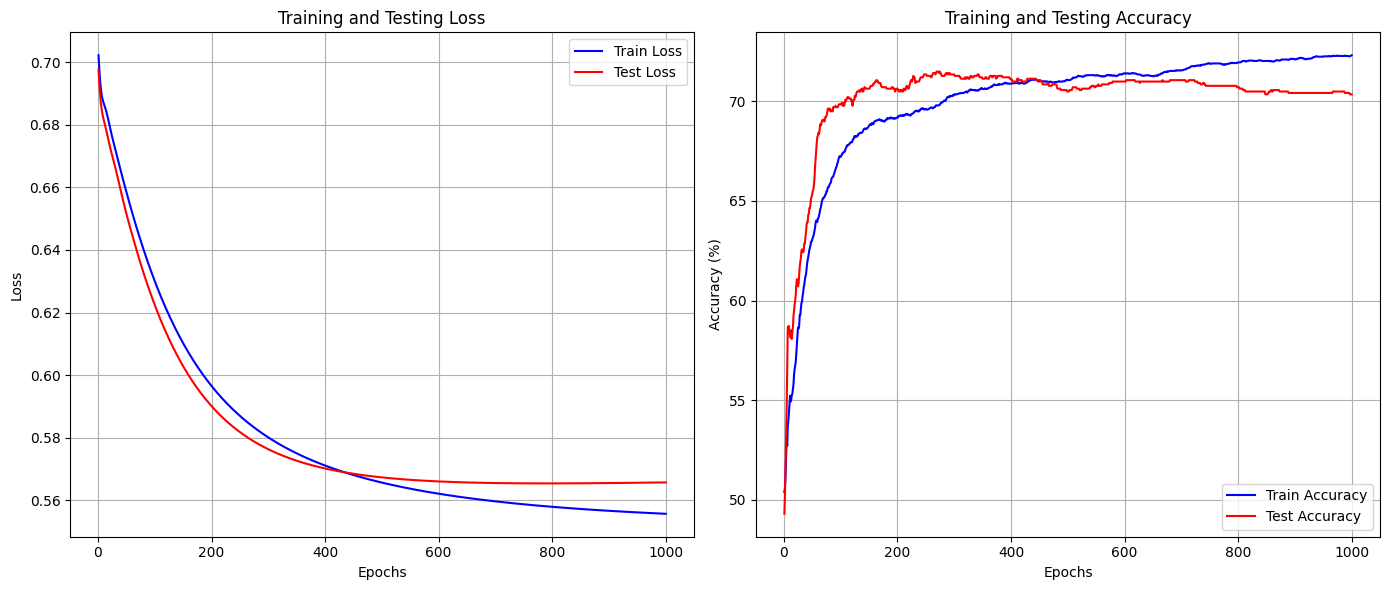

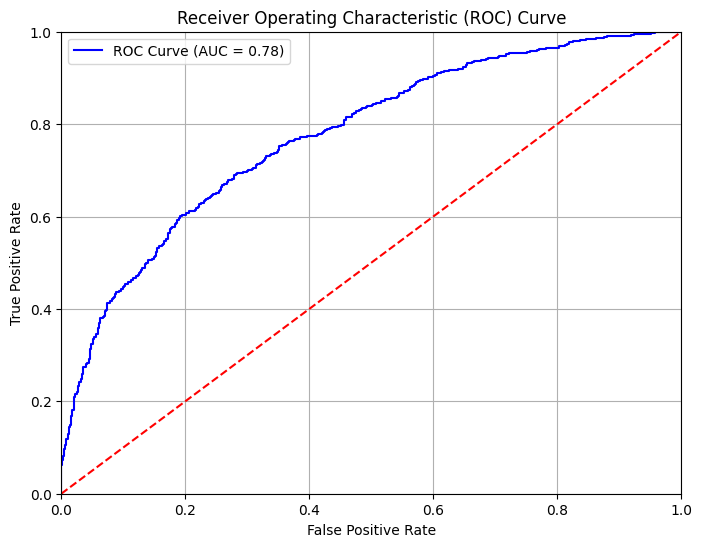

AUC: 0.78
F1 Score: 0.70
Imtafe (other metrics): 7.127659574468085


In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_loss_accuracy(cls_loss, cls_accuracy, test_cls_loss, test_cls_accuracy, epochs):
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), cls_loss, label='Train Loss', color='blue')
    plt.plot(range(1, epochs + 1), test_cls_loss, label='Test Loss', color='red')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), cls_accuracy, label='Train Accuracy', color='blue')
    plt.plot(range(1, epochs + 1), test_cls_accuracy, label='Test Accuracy', color='red')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def plot_roc_curve(fpr, tpr, auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming your classifier training is done and you've collected all metrics
epochs = cls_epochs  # Total number of epochs used for training
plot_loss_accuracy(cls_loss, cls_accuracy, test_cls_loss, test_cls_accuracy, epochs)
plot_roc_curve(fpr, tpr, auc)

# Print the performance metrics
print(f'AUC: {auc:.2f}')
print(f'F1 Score: {f1_score:.2f}')
print(f'Imtafe (other metrics): {imtafe}')


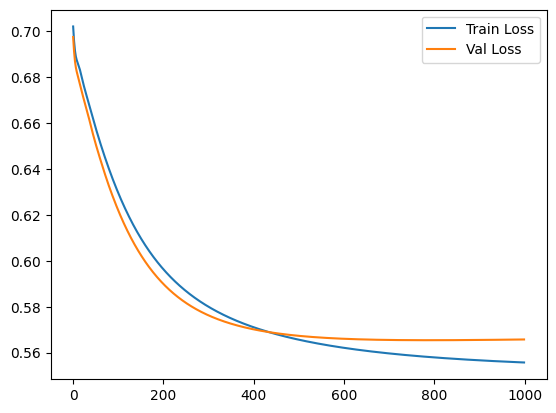

In [153]:
plt.plot(cls_loss, label='Train Loss')
plt.plot(test_cls_loss, label='Val Loss')
plt.legend()

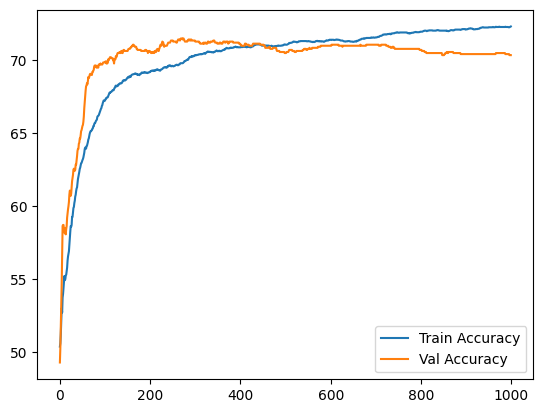

In [154]:
plt.plot(cls_accuracy, label='Train Accuracy')
plt.plot(test_cls_accuracy, label='Val Accuracy')
plt.legend()

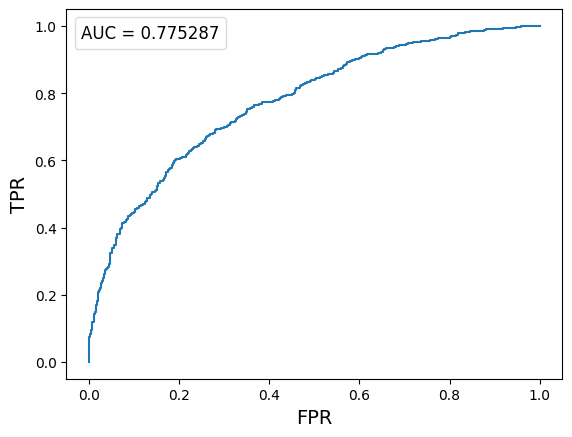

In [155]:
import matplotlib.patches as mpl_patches

font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 12,
        }

plt.plot(fpr, tpr)
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
# plt.text(0.9, 0.9, 'AUC = '+str(auc.round(6)), fontdict=font, wrap=True)
# create a list with two empty handles (or more if needed)
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white",
                                 lw=0, alpha=0)]

# create the corresponding number of labels (= the text you want to display)
labels = []
labels.append("AUC = "+str(auc.round(6)))

# create the legend, supressing the blank space of the empty line symbol and the
# padding between symbol and label by setting handlelenght and handletextpad
plt.legend(handles, labels, loc='best', fontsize='large',
          fancybox=True, framealpha=0.7,
          handlelength=0, handletextpad=0)

In [156]:
print('Accuracy : ', max(test_cls_accuracy))
print('AUC : ', auc)
print('F1 score : ', f1_score)

Accuracy :  71.5
AUC :  0.7752872623185443
F1 score :  0.7034768740031898


In [157]:
gc.collect()

7499

In [158]:
# # augmentation ratio

# parameters = [7,8,9,10]

# for paramx in parameters:
#     # Set up model
#     nodes_per_graph_original = paramx
#     device = 'cuda'
#     num_layer_gnn = 2
#     num_layer_gnn_est = 2
#     qnn_layers = 3
#     emb_dim = 128
#     in_dim = 8
#     inter_dim = 256
#     out_dim = 128
#     JK = 'last'
#     dropout_ratio = 0.1
#     gnn_type = 'gat'
#     lr = 0.001
#     decay = 0
#     aug_ratio = 0.1
#     batch_size = 2000
#     loss_temp = 0.1
#     lamda = 0.1
#     node_est = 'classical'
#     entanglement_type = 'CNOT'
#     encoding_type = 'RY'

#     # Dataset
#     qg_dataset = QuarkGluonGraphDataset(dataset_name='Quark Gluon', raw_dir=main_dir, save_dir='/content',
#                                         data_folder_name=jet_folder_path, datafile_name=jet_file_path, labelsfile_name=jet_file_path,
#                                         datatype='particles', dataset_size=10000, nodes_per_graph=nodes_per_graph_original,
#                                         spectral_augmentation=False, irc_safety_aug=True, device='cuda')

#     # Model
#     gnn = ParticleNetTagger1Path(in_dim, 2)
#     if node_est == 'classical':
#         node_imp_estimator = GNN_imp_estimator(num_layer=num_layer_gnn_est, emb_dim=emb_dim, in_dim=in_dim, JK=JK, drop_ratio=dropout_ratio)
#     if node_est == 'quantum':
#         node_imp_estimator = QGNN_node_estimator(nodes_per_graph_original, qnn_layers, in_dim, device=device,
#                                                  entanglement_type=entanglement_type, encoding_type=encoding_type)

#     model = graphcl(gnn, node_imp_estimator, emb_dim, out_dim)
#     model.to(device)

#     # Optimizer with current learning rate
#     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)


# ############## after training ###############
#     epochs = 50
#     con_loss = []

#     for epoch in range(1, epochs + 1):
#         print("====epoch " + str(epoch))
#         qg_dataset.augment = False
#         train_loss, ra_loss, cp_loss, uni_loss, al_loss = train(epoch, model=model, device=device, dataset=qg_dataset, optimizer=optimizer, batch_size=batch_size,
#                                           nodes_per_graph=qg_dataset.nodes_per_graph, aug_ratio=aug_ratio, loss_temp=loss_temp, lamda=lamda,
#                                           irc_safety=True, q_edge_attr=True, node_est=node_est)
#         con_loss.append(train_loss)
#         print(train_loss)
#         print(ra_loss)
#         print(cp_loss)
#         print('UNI : ', uni_loss)
#         print('ALIGN : ', al_loss)

#     # nodes_per_graph_original = 10
#     test_dataset = QuarkGluonGraphDataset(dataset_name='Quark Gluon', raw_dir=main_dir, save_dir='/content',
#                                         data_folder_name=jet_folder_path, datafile_name=jet_file_path, labelsfile_name=jet_file_path,
#                                         datatype='particles', dataset_size=7000, nodes_per_graph=nodes_per_graph_original, spectral_augmentation=False, irc_safety_aug=True,
#                                         device='cuda')

#     test_samples = torch.tensor(np.arange(2000,7000).astype('int32'))
#     test_sampler = SubsetRandomSampler(test_samples)

#     test_dataloader = test_dataloader = GraphDataLoader(
#         test_dataset, sampler=test_sampler, batch_size=500, drop_last=False
#     )

#     cls_embds = torch.Tensor([])
#     cls_labels = torch.Tensor([])

#     for batched_graph, labels in test_dataloader:
#           graphs = []
#           unbatched_graph = dgl.unbatch(batched_graph)
#           for graph in unbatched_graph:
#             graphs.append(dgl.add_self_loop(graph))
#           batched_graph = dgl.batch(graphs)
#           batch_t = torch.arange(0, batched_graph.batch_size).reshape(-1,1).expand(batched_graph.batch_size, test_dataset.nodes_per_graph).reshape(-1,)

#           ## For custom GNN
#           # cls_emb = gnn.forward(batched_graph.ndata["node_attr"].float(), torch.stack(batched_graph.edges()), batched_graph.edata["edge_attr"].float())

#           ## For ParticleNet
#           pf_feats = batched_graph.ndata["node_attr"].reshape(len(unbatched_graph), nodes_per_graph_original, -1).float()
#           points = pf_feats[:,:,1:3]
#           cls_emb = gnn.forward(points.reshape(points.shape[0], points.shape[2], points.shape[1])
#                              , pf_feats.reshape(pf_feats.shape[0], pf_feats.shape[2], pf_feats.shape[1]), None)
#           cls_emb = cls_emb.reshape(cls_emb.shape[0], cls_emb.shape[2], cls_emb.shape[1])
#           cls_emb = cls_emb.reshape(cls_emb.shape[0]*cls_emb.shape[1], cls_emb.shape[2])

#           # cls_emb = batched_graph.ndata["node_attr"].float()
#           cls_emb = global_mean_pool(cls_emb, batch_t)
#           cls_embds = torch.cat((cls_embds, cls_emb.detach()), 0)     #cls_emb
#           cls_labels = torch.cat((cls_labels, labels))

#     cls_epochs = 1000
#     cls_train_data = cls_embds[ : int(0.8*len(cls_embds))]
#     targets = cls_labels[ : int(0.8*len(cls_embds))]
#     cls_test_data = cls_embds[int(0.8*len(cls_embds)) : ]
#     testtargets = cls_labels[int(0.8*len(cls_embds)) : ]

#     cls_loss, cls_accuracy, test_cls_loss, test_cls_accuracy, fpr, tpr, auc, eB, eS, f1_score, imtafe = train_classifier(cls_epochs, classifier, cls_train_data, targets, cls_test_data, testtargets)

#     # Print the performance metrics
#     print(f'Imtafe (other metrics): {imtafe}')

#     print('Accuracy : ', max(test_cls_accuracy))
#     print('AUC : ', auc)
#     print('F1 score : ', f1_score)
#     # Print or log results for comparison
#     print(f"Finished training with parameter: {paramx}")